# Project: Healthy Home Prediction & Map Visualization

# 1. Set Environment & Libraries

In [129]:
# Set an environment for geopandas & other geo-related libraries 

#%%time 

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

# Geo-related libraries
!pip install geopandas
!pip install osmnx
!pip install contextily
!pip install folium
!pip install plotly_express
!pip install geofeather

# Others
!pip install matplotlib

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

  Cloning git://github.com/geopandas/geopandas.git to /private/var/folders/wm/v8q_p4k13cz5fhz52kr5d_640000gn/T/pip-req-build-9xzbzs3z
  Running command git clone --filter=blob:none --quiet git://github.com/geopandas/geopandas.git /private/var/folders/wm/v8q_p4k13cz5fhz52kr5d_640000gn/T/pip-req-build-9xzbzs3z
^C
ERROR: Operation cancelled by user


In [1]:
# Data manipulation libraries
import os
import pandas as pd
import numpy as np

# Geo-related libraries
from geopandas import gpd
import osmnx as ox
import folium
from folium.plugins import HeatMap
import geopy
from geopy.geocoders import nominatim
from geopy.extra.rate_limiter import RateLimiter
import contextily as ctx
import geofeather
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import Point,MultiPoint
from shapely.ops import nearest_points

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Timer
from tqdm import tqdm,tqdm_notebook

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Model support functions
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler 
from pprint import pprint
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 2. Load Data

In [2]:
file_name = "Home_n_Map.csv"
df_1 = pd.read_csv(file_name)
df_1.head(5)

NO value  NO2 value  PM2p5 value                                geometry  \
0  23.390071  17.539762    17.612700        POINT (-122.3225938 37.80678062)   
1  19.700000  19.956750    15.946719          POINT (-122.32231 37.80614989)   
2  23.611111  23.967768    16.210698        POINT (-122.3223008 37.80642014)   
3  15.714285  18.435184    15.561862  POINT (-122.3222988 37.80587979999999)   
4  27.108695  25.797037    17.120884        POINT (-122.3222671 37.80668898)   

   road_type        zone                                     tract_name  \
0   tertiary  industrial  Census Tract 9819, Alameda County, California   
1  secondary  industrial  Census Tract 9819, Alameda County, California   
2  secondary  industrial  Census Tract 9819, Alameda County, California   
3  secondary  industrial  Census Tract 9819, Alameda County, California   
4  secondary  industrial  Census Tract 9819, Alameda County, California   

        GEOID  state  county   pop_den      wind       temp   Longitude  \
0  6001981900      6       1  8.336845  4.133333  14.950001 -122.322594   
1  6001981900      6       1  8.336845  4.133333  14.950001 -122.322310   
2  6001981900      6       1  8.336845  4.133333  14.950001 -122.322301   
3  6001981900      6       1  8.336845  4.133333  14.950001 -122.322299   
4  6001981900      6       1  8.336845  4.133333  14.950001 -122.322267   

    Latitude Respiratory_HI   Pt_CANCR  
0  37.806781           high  0.7 - 0.8  
1  37.806150           high  0.7 - 0.8  
2  37.806420           high  0.7 - 0.8  
3  37.805880           high  0.7 - 0.8  
4  37.806689           high  0.7 - 0.8

In [3]:
# check a null content(??) and data type
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18286 entries, 0 to 18285
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NO value        18286 non-null  float64
 1   NO2 value       18286 non-null  float64
 2   PM2p5 value     18286 non-null  float64
 3   geometry        18286 non-null  object 
 4   road_type       18286 non-null  object 
 5   zone            18238 non-null  object 
 6   tract_name      18286 non-null  object 
 7   GEOID           18286 non-null  int64  
 8   state           18286 non-null  int64  
 9   county          18286 non-null  int64  
 10  pop_den         18286 non-null  float64
 11  wind            18270 non-null  float64
 12  temp            18270 non-null  float64
 13  Longitude       18286 non-null  float64
 14  Latitude        18286 non-null  float64
 15  Respiratory_HI  18286 non-null  object 
 16  Pt_CANCR        18286 non-null  object 
dtypes: float64(8), int64(3), object

In [4]:
# mapping the data points
gp_1_degree = gpd.GeoDataFrame(df_1,geometry=gpd.points_from_xy(df_1.Longitude,df_1.Latitude),crs={'init':'epsg:4326'})
gp_1_degree.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18286 entries, 0 to 18285
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   NO value        18286 non-null  float64 
 1   NO2 value       18286 non-null  float64 
 2   PM2p5 value     18286 non-null  float64 
 3   geometry        18286 non-null  geometry
 4   road_type       18286 non-null  object  
 5   zone            18238 non-null  object  
 6   tract_name      18286 non-null  object  
 7   GEOID           18286 non-null  int64   
 8   state           18286 non-null  int64   
 9   county          18286 non-null  int64   
 10  pop_den         18286 non-null  float64 
 11  wind            18270 non-null  float64 
 12  temp            18270 non-null  float64 
 13  Longitude       18286 non-null  float64 
 14  Latitude        18286 non-null  float64 
 15  Respiratory_HI  18286 non-null  object  
 16  Pt_CANCR        18286 non-null  object  
dtypes: f

/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


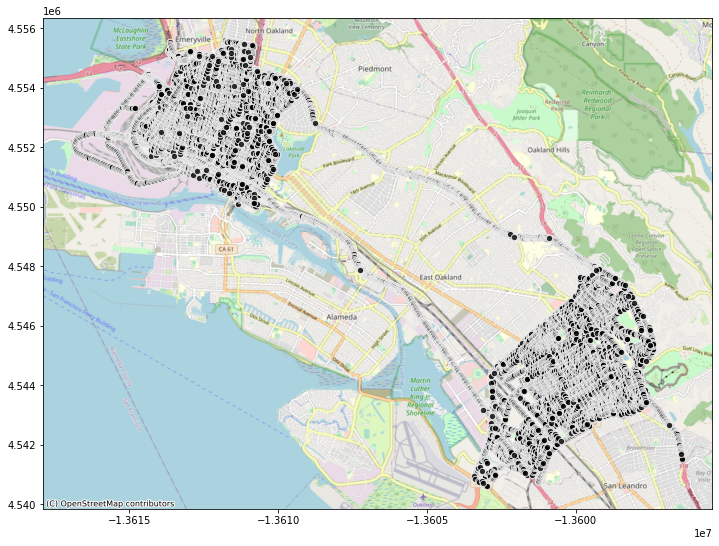

In [5]:
# Mapping the data points
# (b) draw a figure
fig, ax = plt.subplots(figsize =(12,10))
gp_1_degree.to_crs(epsg=3857).plot(ax = ax,
    figsize=(12,12),markersize = 40, color = "black",
    edgecolor = "white",alpha = 0.8,marker = "o");
ctx.add_basemap(ax,source =ctx.providers.OpenStreetMap.Mapnik)

# 3. Data Cleaning

In [6]:
# Check dataframe
df_1.head()

NO value  NO2 value  PM2p5 value                     geometry  road_type  \
0  23.390071  17.539762    17.612700  POINT (-122.32259 37.80678)   tertiary   
1  19.700000  19.956750    15.946719  POINT (-122.32231 37.80615)  secondary   
2  23.611111  23.967768    16.210698  POINT (-122.32230 37.80642)  secondary   
3  15.714285  18.435184    15.561862  POINT (-122.32230 37.80588)  secondary   
4  27.108695  25.797037    17.120884  POINT (-122.32227 37.80669)  secondary   

         zone                                     tract_name       GEOID  \
0  industrial  Census Tract 9819, Alameda County, California  6001981900   
1  industrial  Census Tract 9819, Alameda County, California  6001981900   
2  industrial  Census Tract 9819, Alameda County, California  6001981900   
3  industrial  Census Tract 9819, Alameda County, California  6001981900   
4  industrial  Census Tract 9819, Alameda County, California  6001981900   

   state  county   pop_den      wind       temp   Longitude   Latitude  \
0      6       1  8.336845  4.133333  14.950001 -122.322594  37.806781   
1      6       1  8.336845  4.133333  14.950001 -122.322310  37.806150   
2      6       1  8.336845  4.133333  14.950001 -122.322301  37.806420   
3      6       1  8.336845  4.133333  14.950001 -122.322299  37.805880   
4      6       1  8.336845  4.133333  14.950001 -122.322267  37.806689   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8  
1           high  0.7 - 0.8  
2           high  0.7 - 0.8  
3           high  0.7 - 0.8  
4           high  0.7 - 0.8

## Rename

In [7]:
# Rename (replacing "NO VALUE" to "NO")
df_1 = df_1.rename(columns={'NO value':'NO'})

# Rename (replacing 'NO2 value' to 'NO')
df_1 = df_1.rename(columns={'NO2 value': 'NO2'})

# Rename (replacing 'NO value' to 'NO')
df_1 = df_1.rename(columns={'PM2p5 value': 'PM2p5'})

## Drop Irrelevant Feature

In [8]:
# count unique values for each feature - do this step bf missing data， preveting unnecessary filters
print("*** Cnts of Each Feature ***")
print(df_1.nunique())

*** Cnts of Each Feature ***
NO                16015
NO2               18226
PM2p5             18281
geometry          18281
road_type             6
zone                  5
tract_name           73
GEOID                73
state                 1
county                1
pop_den              73
wind                 45
temp                 80
Longitude         18129
Latitude          18257
Respiratory_HI        3
Pt_CANCR              3
dtype: int64


In [9]:
df_1.head()

NO        NO2      PM2p5                     geometry  road_type  \
0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   tertiary   
1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)  secondary   
2  23.611111  23.967768  16.210698  POINT (-122.32230 37.80642)  secondary   
3  15.714285  18.435184  15.561862  POINT (-122.32230 37.80588)  secondary   
4  27.108695  25.797037  17.120884  POINT (-122.32227 37.80669)  secondary   

         zone                                     tract_name       GEOID  \
0  industrial  Census Tract 9819, Alameda County, California  6001981900   
1  industrial  Census Tract 9819, Alameda County, California  6001981900   
2  industrial  Census Tract 9819, Alameda County, California  6001981900   
3  industrial  Census Tract 9819, Alameda County, California  6001981900   
4  industrial  Census Tract 9819, Alameda County, California  6001981900   

   state  county   pop_den      wind       temp   Longitude   Latitude  \
0      6       1  8.336845  4.133333  14.950001 -122.322594  37.806781   
1      6       1  8.336845  4.133333  14.950001 -122.322310  37.806150   
2      6       1  8.336845  4.133333  14.950001 -122.322301  37.806420   
3      6       1  8.336845  4.133333  14.950001 -122.322299  37.805880   
4      6       1  8.336845  4.133333  14.950001 -122.322267  37.806689   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8  
1           high  0.7 - 0.8  
2           high  0.7 - 0.8  
3           high  0.7 - 0.8  
4           high  0.7 - 0.8

In [10]:
# Drop columns (features)
df_1_drop = df_1.drop(['state','county','tract_name','GEOID'],axis= 1)
df_1_drop.head()

NO        NO2      PM2p5                     geometry  road_type  \
0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   tertiary   
1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)  secondary   
2  23.611111  23.967768  16.210698  POINT (-122.32230 37.80642)  secondary   
3  15.714285  18.435184  15.561862  POINT (-122.32230 37.80588)  secondary   
4  27.108695  25.797037  17.120884  POINT (-122.32227 37.80669)  secondary   

         zone   pop_den      wind       temp   Longitude   Latitude  \
0  industrial  8.336845  4.133333  14.950001 -122.322594  37.806781   
1  industrial  8.336845  4.133333  14.950001 -122.322310  37.806150   
2  industrial  8.336845  4.133333  14.950001 -122.322301  37.806420   
3  industrial  8.336845  4.133333  14.950001 -122.322299  37.805880   
4  industrial  8.336845  4.133333  14.950001 -122.322267  37.806689   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8  
1           high  0.7 - 0.8  
2           high  0.7 - 0.8  
3           high  0.7 - 0.8  
4           high  0.7 - 0.8

# Missing Data

In [11]:
# () Size of the data
print('Num of rows: ' + str(df_1_drop.shape[0])) # count row
print('Num of columns: ' + str(df_1_drop.shape[1])) # count column


Num of rows: 18286
Num of columns: 13


In [12]:
#(1) Check missing data
print('*** Missing Value')
print('Sum of N/A values',df_1_drop.isnull().sum())

*** Missing Value
Sum of N/A values NO                 0
NO2                0
PM2p5              0
geometry           0
road_type          0
zone              48
pop_den            0
wind              16
temp              16
Longitude          0
Latitude           0
Respiratory_HI     0
Pt_CANCR           0
dtype: int64


In [13]:
# (2) Choose a method of handling the missing data - drop all N/A?  avg?  front fill?   back fill?
df_1_miss = df_1_drop.dropna(axis= 0, subset=['zone','wind','temp'])
df_1_miss.head()

NO        NO2      PM2p5                     geometry  road_type  \
0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   tertiary   
1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)  secondary   
2  23.611111  23.967768  16.210698  POINT (-122.32230 37.80642)  secondary   
3  15.714285  18.435184  15.561862  POINT (-122.32230 37.80588)  secondary   
4  27.108695  25.797037  17.120884  POINT (-122.32227 37.80669)  secondary   

         zone   pop_den      wind       temp   Longitude   Latitude  \
0  industrial  8.336845  4.133333  14.950001 -122.322594  37.806781   
1  industrial  8.336845  4.133333  14.950001 -122.322310  37.806150   
2  industrial  8.336845  4.133333  14.950001 -122.322301  37.806420   
3  industrial  8.336845  4.133333  14.950001 -122.322299  37.805880   
4  industrial  8.336845  4.133333  14.950001 -122.322267  37.806689   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8  
1           high  0.7 - 0.8  
2           high  0.7 - 0.8  
3           high  0.7 - 0.8  
4           high  0.7 - 0.8

In [14]:
# (3) Reset index
df_1_miss = df_1_miss.reset_index()

# (4) Check info
df_1_miss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18222 entries, 0 to 18221
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   index           18222 non-null  int64   
 1   NO              18222 non-null  float64 
 2   NO2             18222 non-null  float64 
 3   PM2p5           18222 non-null  float64 
 4   geometry        18222 non-null  geometry
 5   road_type       18222 non-null  object  
 6   zone            18222 non-null  object  
 7   pop_den         18222 non-null  float64 
 8   wind            18222 non-null  float64 
 9   temp            18222 non-null  float64 
 10  Longitude       18222 non-null  float64 
 11  Latitude        18222 non-null  float64 
 12  Respiratory_HI  18222 non-null  object  
 13  Pt_CANCR        18222 non-null  object  
dtypes: float64(8), geometry(1), int64(1), object(4)
memory usage: 1.9+ MB


In [15]:
#(5) remove index
df_1_miss = df_1_miss.drop(['index'],axis= 1)

## Duplicated Values

In [16]:
# (0) Size of data
print("Num of rows: " + str(df_1_miss.shape[0]))
print("Num of colums: " + str(df_1_miss.shape[1]))

Num of rows: 18222
Num of colums: 13


In [17]:
# (1) Extract duplicated row
df_1_miss[df_1_miss.duplicated()]

NO        NO2      PM2p5                     geometry  road_type  \
174   32.059862  24.190178  19.514652  POINT (-122.30853 37.81503)  secondary   
504   16.426667  19.134740  18.727645  POINT (-122.30013 37.80641)  secondary   
7161  92.638344  45.426999  28.987625  POINT (-122.23379 37.77509)   motorway   

            zone      pop_den      wind       temp   Longitude   Latitude  \
174   industrial   220.026011  4.125000  15.000001 -122.308528  37.815028   
504        mixed  3520.358174  4.083333  15.083335 -122.300129  37.806411   
7161       mixed  2351.277070  4.091667  15.166668 -122.233788  37.775092   

     Respiratory_HI   Pt_CANCR  
174            high  0.7 - 0.8  
504            high  0.7 - 0.8  
7161           high  0.7 - 0.8

In [18]:
# (2) Print the first & last rows BEFORE removing duplicated values
df_1_miss.iloc[[0,-1]]

NO        NO2      PM2p5                     geometry road_type  \
0      23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)  tertiary   
18221  18.842105  16.122072   9.270166  POINT (-122.13903 37.73246)  motorway   

              zone     pop_den      wind       temp   Longitude   Latitude  \
0       industrial    8.336845  4.133333  14.950001 -122.322594  37.806781   
18221  residential  486.040242  3.816667  15.041669 -122.139033  37.732464   

      Respiratory_HI   Pt_CANCR  
0               high  0.7 - 0.8  
18221            low      < 0.4

In [19]:
# # Remove duplicated row 
# # (method one) keep='first' -> the first occurrence gets kept, and all others get identified as duplicates.
# new = df.drop_duplicates(subset=['column1'], keep='first', inplace=False)
# # (method two) keep='last' -> the last occurrence gets kept, and all others get identified as duplicates.
# new = df.drop_duplicates(subset=['column1'], keep='last', inplace=False)
# # (method three) keep='False' -> remove all duplicates
# new = df.drop_duplicates(subset=['column1'], keep='false', inplace=False)


# (3) Remove duplicated values
df_1_dup = df_1_miss.drop_duplicates()
df_1_dup.tail(2)

NO        NO2      PM2p5                     geometry road_type  \
18220   9.333333   9.039947  11.325624  POINT (-122.15509 37.77014)  motorway   
18221  18.842105  16.122072   9.270166  POINT (-122.13903 37.73246)  motorway   

              zone      pop_den      wind       temp   Longitude   Latitude  \
18220  residential  1475.818172  3.766667  14.600001 -122.155090  37.770138   
18221  residential   486.040242  3.816667  15.041669 -122.139033  37.732464   

      Respiratory_HI Pt_CANCR  
18220            low    < 0.4  
18221            low    < 0.4

In [20]:
# (4) Reset index, creating a new df 
df_1_dup.reset_index(inplace=True)
# (5) Check duplicated values
df_1_dup[df_1_dup.duplicated()]

Empty DataFrame
Columns: [index, NO, NO2, PM2p5, geometry, road_type, zone, pop_den, wind, temp, Longitude, Latitude, Respiratory_HI, Pt_CANCR]
Index: []

In [21]:
# (6) Print the first & last rows AFTER removing duplicated values
df_1_dup.iloc[[0,-1]]

index         NO        NO2      PM2p5                     geometry  \
0          0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
18218  18221  18.842105  16.122072   9.270166  POINT (-122.13903 37.73246)   

      road_type         zone     pop_den      wind       temp   Longitude  \
0      tertiary   industrial    8.336845  4.133333  14.950001 -122.322594   
18218  motorway  residential  486.040242  3.816667  15.041669 -122.139033   

        Latitude Respiratory_HI   Pt_CANCR  
0      37.806781           high  0.7 - 0.8  
18218  37.732464            low      < 0.4

## Outliers

In [22]:
# Copy
df_1_out = df_1_dup.copy()

df_1_out.head(1)

index         NO        NO2    PM2p5                     geometry  \
0      0  23.390071  17.539762  17.6127  POINT (-122.32259 37.80678)   

  road_type        zone   pop_den      wind       temp   Longitude   Latitude  \
0  tertiary  industrial  8.336845  4.133333  14.950001 -122.322594  37.806781   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8

<AxesSubplot: ylabel='temp'>

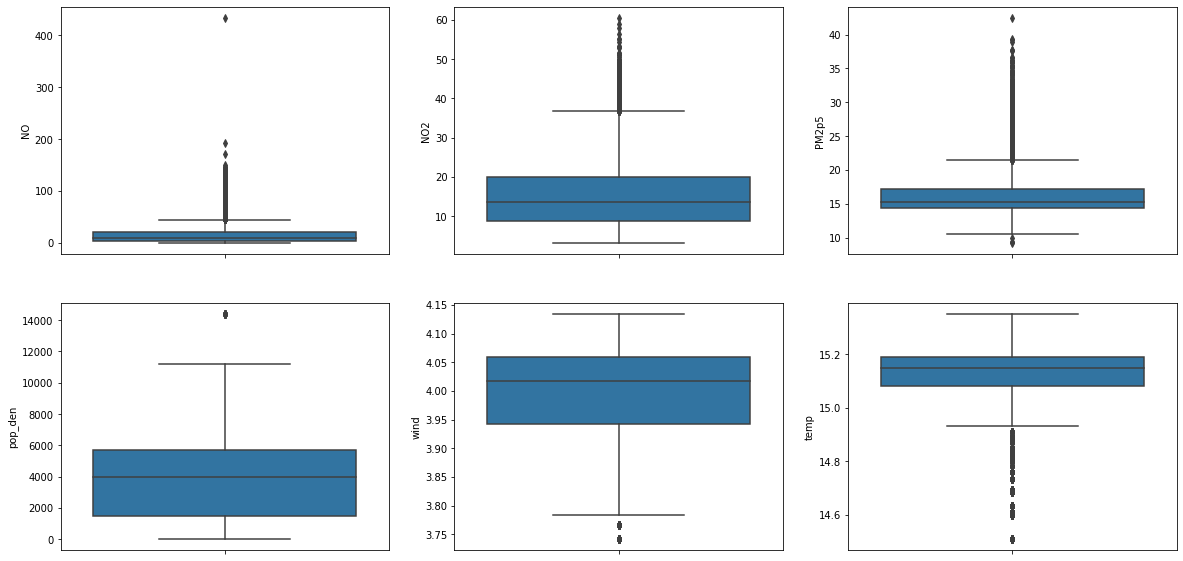

In [23]:
# Checking outliers

_,axss = plt.subplots(2,3, figsize=[20,10])  # create a 2x3 matrix = 6 figures
sns.boxplot(y ='NO', data=df_1_out, ax=axss[0, 0])
sns.boxplot(y ='NO2', data=df_1_out, ax=axss[0, 1])
sns.boxplot(y ='PM2p5', data=df_1_out, ax=axss[0, 2])
sns.boxplot(y ='pop_den', data=df_1_out, ax=axss[1][0])
sns.boxplot(y ='wind', data=df_1_out, ax=axss[1][1])
sns.boxplot(y ='temp', data=df_1_out, ax=axss[1][2])

In [24]:
# Mannually remove outliers based on knowledge
# if NO > 200 -> let all of them equl to 200
df_1_out.loc[df_1_out['NO'] > 200, 'NO'] = 200

# 4. Feature Engineering

## Oakland city

In [25]:
# Import oakland street and map data
Oakland_poly = ox.geocode_to_gdf('Oakland, California')

Oakland_poly

geometry  bbox_north  bbox_south  \
0  POLYGON ((-122.35588 37.83573, -122.35009 37.8...   37.885426   37.633676   

   bbox_east   bbox_west   place_id  osm_type   osm_id        lat         lon  \
0 -122.11442 -122.355881  298690193  relation  2833530  37.804456 -122.271356   

                                        display_name     class  \
0  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   

             type  importance  
0  administrative    0.851796

<AxesSubplot: >

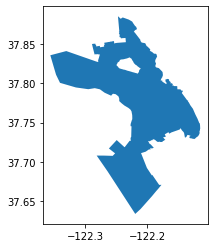

In [26]:
Oakland_poly.plot()

### convert geo

In [27]:
# Check
Oakland_poly.crs, gp_1_degree.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: +init=epsg:4326 +type=crs>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - lon[east]: Longitude (degree)
 - lat[north]: Latitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [28]:
# Conver geometey object -> geo df
gp_1_degree = gpd.GeoDataFrame(df_1_out, geometry = df_1_out['geometry'], crs={'init' :'epsg:4326'})

Oakland_poly.crs, gp_1_degree.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: +init=epsg:4326 +type=crs>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - lon[east]: Longitude (degree)
 - lat[north]: Latitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [29]:
gp_1_degree.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

   road_type        zone   pop_den      wind       temp   Longitude  \
0   tertiary  industrial  8.336845  4.133333  14.950001 -122.322594   
1  secondary  industrial  8.336845  4.133333  14.950001 -122.322310   

    Latitude Respiratory_HI   Pt_CANCR  
0  37.806781           high  0.7 - 0.8  
1  37.806150           high  0.7 - 0.8

### Spatial-join

In [30]:
# spatial-join the dataset of pollutant and health with the Oakland polygon grid (make sure all data represent Oakland city)
gpd_1_city = gpd.sjoin(gp_1_degree, Oakland_poly, how="inner", op="intersects")

gpd_1_city.head(2)

/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/wm/v8q_p4k13cz5fhz52kr5d_640000gn/T/ipykernel_54733/4254521258.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gpd_1_city = gpd.sjoin(gp_1_degree, Oakland_poly, how="inner", op="intersects")


index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

   road_type        zone   pop_den      wind       temp  ...   bbox_west  \
0   tertiary  industrial  8.336845  4.133333  14.950001  ... -122.355881   
1  secondary  industrial  8.336845  4.133333  14.950001  ... -122.355881   

    place_id  osm_type   osm_id        lat         lon  \
0  298690193  relation  2833530  37.804456 -122.271356   
1  298690193  relation  2833530  37.804456 -122.271356   

                                        display_name     class  \
0  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   
1  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   

             type  importance  
0  administrative    0.851796  
1  administrative    0.851796  

[2 rows x 28 columns]

In [31]:
# count unique values for each feature
print("*** Cnts of Each Feature ***")
print(gpd_1_city.nunique())

*** Cnts of Each Feature ***
index             18219
NO                15963
NO2               18162
PM2p5             18217
geometry          18217
road_type             6
zone                  5
pop_den              70
wind                 45
temp                 80
Longitude         18067
Latitude          18194
Respiratory_HI        3
Pt_CANCR              3
index_right           1
bbox_north            1
bbox_south            1
bbox_east             1
bbox_west             1
place_id              1
osm_type              1
osm_id                1
lat                   1
lon                   1
display_name          1
class                 1
type                  1
importance            1
dtype: int64


In [32]:
gpd_1_city = gpd_1_city.drop(['index_right', 'bbox_east', 'bbox_north', 'bbox_south', 'bbox_west'], axis=1)

## City structure: Roads

### city

In [33]:
# (1) grab street data (roads and intersections) for entire city
oak_streets = ox.graph_from_place('Oakland, California', network_type = 'drive')
nodes, edges = ox.graph_to_gdfs(oak_streets)

In [34]:
Oakland_poly.head(5)

geometry  bbox_north  bbox_south  \
0  POLYGON ((-122.35588 37.83573, -122.35009 37.8...   37.885426   37.633676   

   bbox_east   bbox_west   place_id  osm_type   osm_id        lat         lon  \
0 -122.11442 -122.355881  298690193  relation  2833530  37.804456 -122.271356   

                                        display_name     class  \
0  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   

             type  importance  
0  administrative    0.851796

In [35]:
nodes.head(1)

y           x ref            highway  street_count  \
osmid                                                                  
30362888  37.825844 -122.303049  8A  motorway_junction             3   

                             geometry  
osmid                                  
30362888  POINT (-122.30305 37.82584)

In [36]:
edges.head(1)

osmid  oneway lanes   ref   highway maxspeed  \
u        v          key                                                     
30362888 1943438853 0    710721717    True     7  I 80  motorway   50 mph   

                        reversed   length  \
u        v          key                     
30362888 1943438853 0      False  135.576   

                                                                  geometry  \
u        v          key                                                      
30362888 1943438853 0    LINESTRING (-122.30305 37.82584, -122.30455 37...   

                        bridge name tunnel access junction  
u        v          key                                     
30362888 1943438853 0      NaN  NaN    NaN    NaN      NaN

<AxesSubplot: >

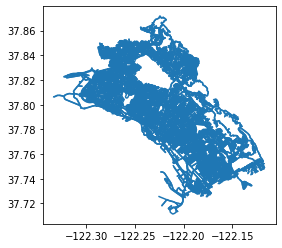

In [37]:
edges.plot()

### road

In [38]:
# (2 - a) Identify roads 
oakland_rds = edges.copy()
print(oakland_rds['highway'].value_counts())
print ("Num of rows: " + str(oakland_rds.shape[0])) # row count
print ("Num of columns: " + str(oakland_rds.shape[1])) # col count

residential                        15071
secondary                           2929
tertiary                            2495
primary                              773
motorway_link                        319
unclassified                         229
motorway                             204
secondary_link                       109
living_street                         78
trunk                                 58
tertiary_link                         43
trunk_link                            38
primary_link                          15
[residential, unclassified]            8
[living_street, residential]           2
[secondary_link, motorway_link]        2
[secondary, residential]               1
Name: highway, dtype: int64
Num of rows: 22374
Num of columns: 14


In [39]:
# (2 - b) Clean roads 

# remove '_link' in xxx_link & add it to xxx 
# (e.g., motorway_link is added on motorway )
oakland_rds['highway'] = oakland_rds['highway'].str.replace('_link', '')


# 'trunk'  -->  'secondary'
oakland_rds['highway'] = np.where(oakland_rds['highway'] == 'trunk', 'secondary', oakland_rds['highway'])


# 'living_street' --> 'residential'
oakland_rds['highway'] = np.where(oakland_rds['highway'] == 'living_street', 'residential', oakland_rds['highway'])

# Check results
print(oakland_rds['highway'].value_counts())

residential     15149
secondary        3134
tertiary         2538
primary           788
motorway          523
unclassified      229
Name: highway, dtype: int64


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: xlabel='highway', ylabel='count'>

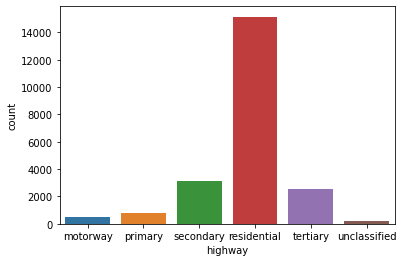

In [40]:
sns.countplot(oakland_rds['highway'])

### map

In [41]:
# (3) Map them out 

# grab subsets of roadtypes
oakland_highways = oakland_rds[oakland_rds.highway=='motorway']
oakland_primary = oakland_rds[oakland_rds.highway == 'primary']
oakland_secondary = oakland_rds[oakland_rds.highway == 'secondary']
oakland_tertiary = oakland_rds[oakland_rds.highway == 'tertiary']
oakland_resid = oakland_rds[oakland_rds.highway == 'resid']

oakland_highways.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

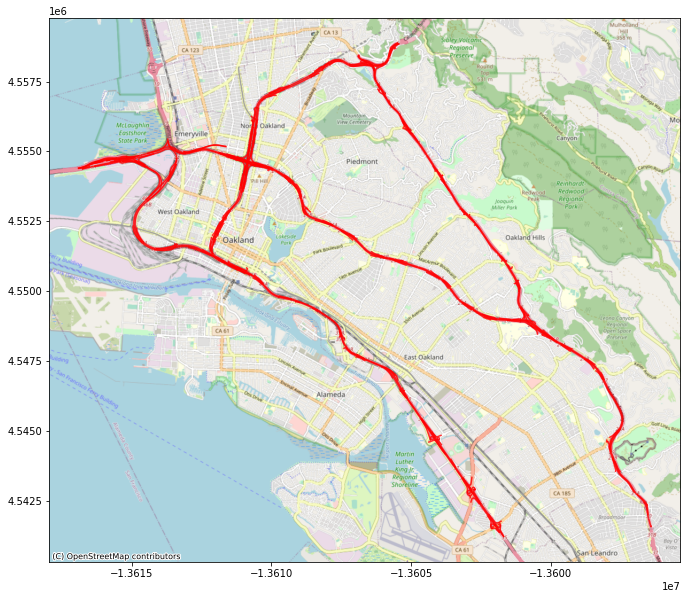

In [42]:
# Highway
fig, ax = plt.subplots(figsize = (12,10))
oakland_highways.to_crs(epsg=3857).plot(ax = ax, 
                        figsize = (12,12),
                        markersize = 40,
                        color = 'red',
                        edgecolor = 'white',
                        alpha =0.8,
                        marker = 'o')
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)

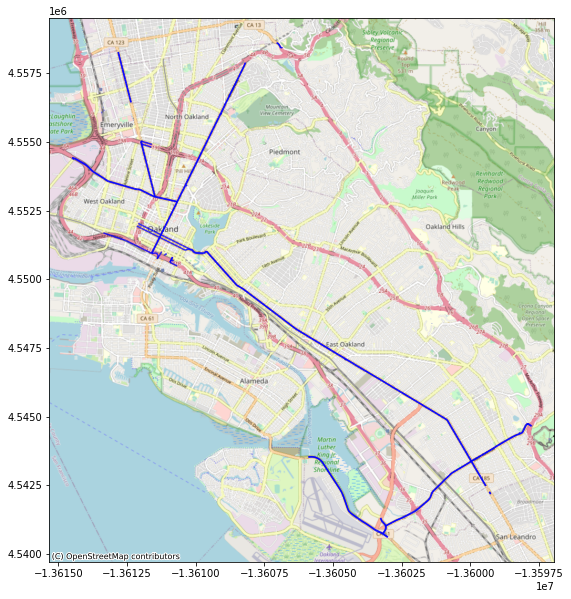

In [43]:
# primary
fig, ax = plt.subplots(figsize = (12,10))
oakland_primary.to_crs(epsg=3857).plot(ax = ax, 
                        figsize = (12,12),
                        markersize = 40,
                        color = 'blue',
                        edgecolor = 'white',
                        alpha =0.8,
                        marker = 'o')
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)

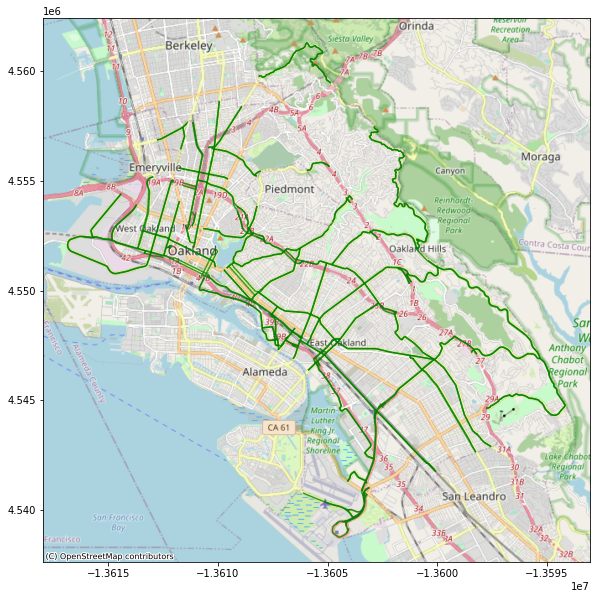

In [44]:
# oakland_secondary
fig, ax = plt.subplots(figsize = (12,10))
oakland_secondary.to_crs(epsg=3857).plot(ax = ax, 
                        figsize = (12,12),
                        markersize = 40,
                        color = 'green',
                        edgecolor = 'white',
                        alpha =0.8,
                        marker = 'o')
ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)

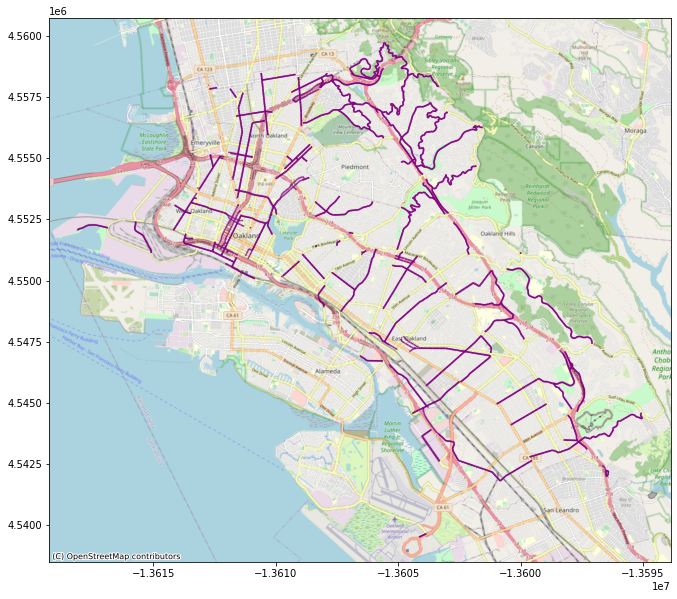

In [45]:
# Tertiary road
fig, ax = plt.subplots(figsize=(12, 10))
oakland_tertiary.to_crs(epsg=3857).plot(ax = ax,
                figsize=(12,12),
                markersize=40,
               color="purple",
               edgecolor="white",
               alpha=0.8,
               marker="o"
            );
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

### road type

In [46]:
gpd_1_city.crs, oakland_rds.crs

(<Geographic 2D CRS: +init=epsg:4326 +type=crs>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - lon[east]: Longitude (degree)
 - lat[north]: Latitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [47]:
#remove doubled road IDs, this is only 20 roads out of 22335, but they cause subsetting problems
#oakland_rds = remove_doubleID_streets(edges)

def find_closest_road(gps, roads, buffer_dist = 0.0003):
    '''Find the closest road to a GPS point. If no roads are within 30m the point is considered outside
    of a known roadway'''
    road_index = roads.sindex
    circle = gps.buffer(buffer_dist) #build buffer around point (~ 30 meters)

    possible_matches_index = list(road_index.intersection(circle.bounds)) #get index of possible nearest roads
    possible_matches = roads.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(circle)].copy()

    #get distances to roads in buffer
    precise_matches['distance'] = precise_matches['geometry'].distance(gps)
    
    if precise_matches['distance'].empty is False:
        return(precise_matches.sort_values(['distance']).drop_duplicates('distance').iloc[0, 3])
    else:
        return('outside_area')


# # Create a new categorical feature - calculate road_type for each point ...
# gpd_1_city['road_type'] = gpd_1_city['geometry'].apply(find_closest_road, roads = oakland_rds)
# gpd_1_city.road_type.value_counts()

### Road distance

In [48]:
gpd_1_city.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
# Conver geometey from degree -> meter (utm: unit in meter)
# 'epsg:32610' == meter 
# 'epsg:4326' == degree
gpd_1_city_utm = gpd_1_city.to_crs({'init': 'epsg:32610'}).copy()      # much faster to do the re-projection to meters
highway_utm = oakland_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = oakland_primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = oakland_secondary.to_crs({'init': 'epsg:32610'}).copy()
tertiary_utm = oakland_tertiary.to_crs({'init': 'epsg:32610'}).copy()


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initial

In [50]:
# UDF
def distance_to_roadway(gps, roadway):
    '''Calculate distance from GPS point to nearest road line polygon'''
    dists = []
    for i in roadway.geometry:
        dists.append(i.distance(gps))
    return(np.min(dists))

In [51]:
# Calculate distance to nearest highway
tqdm.pandas()
gpd_1_city['closest_highway'] = gpd_1_city_utm['geometry'].progress_apply(distance_to_roadway, roadway = highway_utm)
# gpd_1_city['closest_highway'] = gpd_1_city['geometry'].apply(distance_to_roadway, roadway = highway_utm)

100%|██████████| 18219/18219 [01:35<00:00, 191.56it/s]


In [79]:
# Calculate distance to nearest primary road
tqdm.pandas()
gpd_1_city['closest_primary'] = gpd_1_city_utm['geometry'].progress_apply(distance_to_roadway, roadway = primary_utm)

100%|██████████| 18219/18219 [01:41<00:00, 179.26it/s]


In [53]:
# Calculate distance to nearest secondary road
tqdm.pandas()
gpd_1_city['closest_secondary'] = gpd_1_city_utm['geometry'].progress_apply(distance_to_roadway, roadway = secondary_utm)

100%|██████████| 18219/18219 [07:47<00:00, 38.94it/s]


In [54]:
# Calculate distance to nearest tertiary road
tqdm.pandas()
gpd_1_city['closest_tertiary'] = gpd_1_city_utm['geometry'].progress_apply(distance_to_roadway, roadway = tertiary_utm)

100%|██████████| 18219/18219 [06:04<00:00, 50.04it/s]


In [55]:
gpd_1_city.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

   road_type        zone   pop_den      wind       temp  ...        lat  \
0   tertiary  industrial  8.336845  4.133333  14.950001  ...  37.804456   
1  secondary  industrial  8.336845  4.133333  14.950001  ...  37.804456   

          lon                                       display_name     class  \
0 -122.271356  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   
1 -122.271356  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   

             type importance  closest_highway  closest_primary  \
0  administrative   0.851796      1529.354679      2576.575272   
1  administrative   0.851796      1510.616902      2605.774822   

   closest_secondary closest_tertiary  
0       3.000134e+01         0.003395  
1       5.009606e-08        63.387249  

[2 rows x 27 columns]

## City Structure: traffic signal & stop sign


### Identify

In [56]:
# (1) Identify traffic signals & stop signs 
nodes['highway'].value_counts()

traffic_signals      778
stop                 355
turning_circle       322
motorway_junction    131
crossing               9
mini_roundabout        4
trailhead              3
Name: highway, dtype: int64

In [57]:
nodes.head(2)

y           x  ref            highway  street_count  \
osmid                                                                   
30362888  37.825844 -122.303049   8A  motorway_junction             3   
30363957  37.825477 -122.307034  NaN                NaN             3   

                             geometry  
osmid                                  
30362888  POINT (-122.30305 37.82584)  
30363957  POINT (-122.30703 37.82548)

In [58]:
nodes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Map

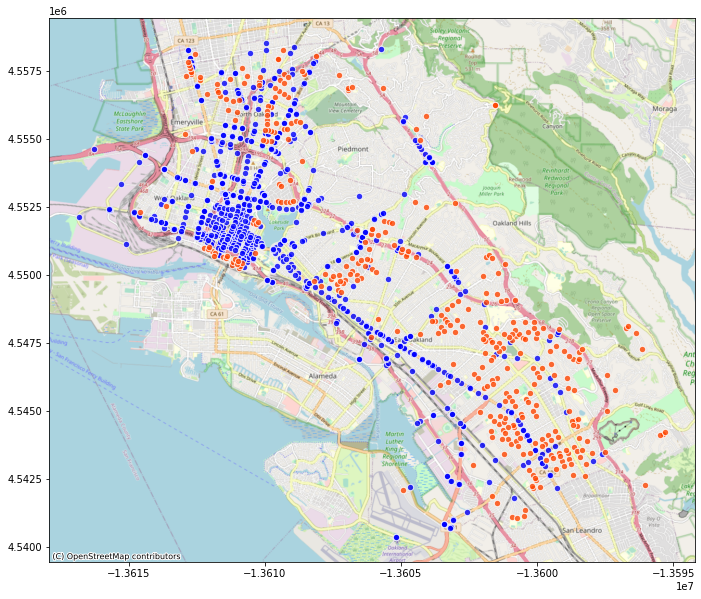

In [59]:
# (2) Map them out

trafic_signals = nodes[nodes['highway'] == 'traffic_signals']
stop_cross = nodes[nodes['highway'] == 'stop']


# Traffic signal: blue
# Stop sign: red
fig, ax = plt.subplots(figsize=(12, 10))
trafic_signals.to_crs(epsg=3857).plot(ax = ax,
                figsize=(12,12),
                markersize=40,
               color="blue",
               edgecolor="white",
               alpha=0.8,
               marker="o"
            );
stop_cross.to_crs(epsg=3857).plot(ax = ax,
                figsize=(12,12),
                markersize=40,
               color="orangered",
               edgecolor="white",
               alpha=0.8,
               marker="o"
            );
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [60]:
trafic_signals.head()

y           x  ref          highway  street_count  \
osmid                                                                 
52982613  37.786596 -122.196234  NaN  traffic_signals             4   
52982915  37.800221 -122.278227  NaN  traffic_signals             4   
52984139  37.753375 -122.209483  NaN  traffic_signals             3   
52986119  37.796401 -122.268746  NaN  traffic_signals             4   
52986125  37.795819 -122.269104  NaN  traffic_signals             5   

                             geometry  
osmid                                  
52982613  POINT (-122.19623 37.78660)  
52982915  POINT (-122.27823 37.80022)  
52984139  POINT (-122.20948 37.75337)  
52986119  POINT (-122.26875 37.79640)  
52986125  POINT (-122.26910 37.79582)

### intersection & traffic signal

In [61]:
# (3 - a) Conver geometey from degree -> meter (utm: unit in meter)
# 'epsg:32610' == meter 
# 'epsg:4326' == degree
traffic_sig_utm = trafic_signals.to_crs({'init': 'epsg:32610'}).copy()    # much faster to do the re-projection to meters
stop_sign_utm = stop_cross.to_crs({'init': 'epsg:32610'}).copy()      


# (3 - b) set UDF

def nearest_intersection(gps, intersections):
    ''' Calculates distance from GPS point to nearest intersection'''
    closest_point = nearest_points(gps, MultiPoint(intersections.values))[1]
    return(gps.distance(closest_point))

/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [62]:
# (3 - c) Calculate distance to nearest traffic signal
tqdm.pandas()
gpd_1_city['trafic_signal_dist'] = gpd_1_city_utm['geometry'].progress_apply(nearest_intersection, intersections = traffic_sig_utm['geometry'])
# gpd_1_city['trafic_signal_dist'] = gpd_1_city['geometry'].apply(nearest_intersection, intersections = traffic_sig_utm['geometry'])

100%|██████████| 18219/18219 [01:01<00:00, 296.15it/s]


In [63]:
# (3 - c) Calculate distance to nearest stop sign
tqdm.pandas()
gpd_1_city['stop_sign_dist'] = gpd_1_city_utm['geometry'].progress_apply(nearest_intersection, intersections = stop_sign_utm['geometry'])

100%|██████████| 18219/18219 [00:28<00:00, 638.99it/s]


## Category Encoding

In [64]:
gpd_1_city.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

   road_type        zone   pop_den      wind       temp  ...  \
0   tertiary  industrial  8.336845  4.133333  14.950001  ...   
1  secondary  industrial  8.336845  4.133333  14.950001  ...   

                                        display_name     class  \
0  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   
1  Oakland, Alameda County, CAL Fire Northern Reg...  boundary   

             type importance  closest_highway closest_primary  \
0  administrative   0.851796      1529.354679     2576.575272   
1  administrative   0.851796      1510.616902     2605.774822   

   closest_secondary  closest_tertiary  trafic_signal_dist stop_sign_dist  
0       3.000134e+01          0.003395           30.001344    1818.142667  
1       5.009606e-08         63.387249           63.387249    1800.106387  

[2 rows x 29 columns]

In [65]:
zone = gpd_1_city['zone']
road_type = gpd_1_city['road_type']

In [66]:
# One-hot encoding: convert category features to numerical features（0 & 1） - spliting into diff columns
gpd_1_city = pd.get_dummies(gpd_1_city, columns=['road_type'], drop_first=False)      # drop_first=False: do not remove a label to reduce multicollision 
gpd_1_city = pd.get_dummies(gpd_1_city, columns=['zone'], drop_first=False)

gpd_1_city.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

    pop_den      wind       temp   Longitude   Latitude  ...  \
0  8.336845  4.133333  14.950001 -122.322594  37.806781  ...   
1  8.336845  4.133333  14.950001 -122.322310  37.806150  ...   

  road_type_primary road_type_residential  road_type_secondary  \
0                 0                     0                    0   
1                 0                     0                    1   

  road_type_tertiary  road_type_unclassified  zone_commercial  \
0                  1                       0                0   
1                  0                       0                0   

   zone_industrial zone_mixed zone_open_space zone_residential  
0                1          0               0                0  
1                1          0               0                0  

[2 rows x 38 columns]

In [67]:
# Merge them back - for visualization
# axis = 1: rows invariant，but features increased
gpd_1_city = pd.concat([gpd_1_city, zone], axis = 1)
gpd_1_city = pd.concat([gpd_1_city, road_type], axis = 1)

gpd_1_city.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

    pop_den      wind       temp   Longitude   Latitude  ...  \
0  8.336845  4.133333  14.950001 -122.322594  37.806781  ...   
1  8.336845  4.133333  14.950001 -122.322310  37.806150  ...   

  road_type_secondary road_type_tertiary  road_type_unclassified  \
0                   0                  1                       0   
1                   1                  0                       0   

  zone_commercial  zone_industrial  zone_mixed  zone_open_space  \
0               0                1           0                0   
1               0                1           0                0   

  zone_residential        zone  road_type  
0                0  industrial   tertiary  
1                0  industrial  secondary  

[2 rows x 40 columns]

## Data Preparation

In [68]:
gpd_1_city.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18219 entries, 0 to 18218
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   index                   18219 non-null  int64   
 1   NO                      18219 non-null  float64 
 2   NO2                     18219 non-null  float64 
 3   PM2p5                   18219 non-null  float64 
 4   geometry                18219 non-null  geometry
 5   pop_den                 18219 non-null  float64 
 6   wind                    18219 non-null  float64 
 7   temp                    18219 non-null  float64 
 8   Longitude               18219 non-null  float64 
 9   Latitude                18219 non-null  float64 
 10  Respiratory_HI          18219 non-null  object  
 11  Pt_CANCR                18219 non-null  object  
 12  place_id                18219 non-null  int64   
 13  osm_type                18219 non-null  object  
 14  osm_id        

### drop

In [69]:
# Drop features
gpd_1_city = gpd_1_city.drop(['index', 'Pt_CANCR'], axis=1)

### health conversion

In [70]:
# if df['Respiratory_HI'] contains 'high', replace "high" to "3" and save into df['Respiratory_HI']
gpd_1_city['Respiratory_HI'] = np.where(gpd_1_city['Respiratory_HI'].str.contains('high'), '3', gpd_1_city['Respiratory_HI'])

# if df['Respiratory_HI'] contains 'moderate', replace "high" to "2" and save into df['Respiratory_HI']
gpd_1_city['Respiratory_HI'] = np.where(gpd_1_city['Respiratory_HI'].str.contains('moderate'), '2', gpd_1_city['Respiratory_HI'])

# if df['Respiratory_HI'] contains 'low', replace "high" to "1" and save into df['Respiratory_HI']
gpd_1_city['Respiratory_HI'] = np.where(gpd_1_city['Respiratory_HI'].str.contains('low'), '1', gpd_1_city['Respiratory_HI'])

# convert object to float
gpd_1_city["Respiratory_HI"] = gpd_1_city.Respiratory_HI.astype(float)

gpd_1_city.head(3)
# gpd_1_city.Respiratory_HI.value_counts()

NO        NO2      PM2p5                     geometry   pop_den  \
0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)  8.336845   
1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)  8.336845   
2  23.611111  23.967768  16.210698  POINT (-122.32230 37.80642)  8.336845   

       wind       temp   Longitude   Latitude  Respiratory_HI  ...  \
0  4.133333  14.950001 -122.322594  37.806781             3.0  ...   
1  4.133333  14.950001 -122.322310  37.806150             3.0  ...   
2  4.133333  14.950001 -122.322301  37.806420             3.0  ...   

   road_type_secondary road_type_tertiary  road_type_unclassified  \
0                    0                  1                       0   
1                    1                  0                       0   
2                    1                  0                       0   

   zone_commercial  zone_industrial zone_mixed zone_open_space  \
0                0                1          0               0   
1                0                1          0               0   
2                0                1          0               0   

  zone_residential        zone  road_type  
0                0  industrial   tertiary  
1                0  industrial  secondary  
2                0  industrial  secondary  

[3 rows x 38 columns]

In [71]:
gpd_1_city.zone.value_counts()

residential    9873
mixed          3485
commercial     3218
industrial     1419
open_space      224
Name: zone, dtype: int64

In [72]:
gpd_1_city.road_type.value_counts()

residential     8368
motorway        3958
secondary       2794
tertiary        1651
primary         1281
unclassified     167
Name: road_type, dtype: int64

In [73]:
gpd_1_city.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18219 entries, 0 to 18218
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   NO                      18219 non-null  float64 
 1   NO2                     18219 non-null  float64 
 2   PM2p5                   18219 non-null  float64 
 3   geometry                18219 non-null  geometry
 4   pop_den                 18219 non-null  float64 
 5   wind                    18219 non-null  float64 
 6   temp                    18219 non-null  float64 
 7   Longitude               18219 non-null  float64 
 8   Latitude                18219 non-null  float64 
 9   Respiratory_HI          18219 non-null  float64 
 10  place_id                18219 non-null  int64   
 11  osm_type                18219 non-null  object  
 12  osm_id                  18219 non-null  int64   
 13  lat                     18219 non-null  float64 
 14  lon           

In [74]:
gpd_1_city.columns

Index(['NO', 'NO2', 'PM2p5', 'geometry', 'pop_den', 'wind', 'temp',
       'Longitude', 'Latitude', 'Respiratory_HI', 'place_id', 'osm_type',
       'osm_id', 'lat', 'lon', 'display_name', 'class', 'type', 'importance',
       'closest_highway', 'closest_primary', 'closest_secondary',
       'closest_tertiary', 'trafic_signal_dist', 'stop_sign_dist',
       'road_type_motorway', 'road_type_primary', 'road_type_residential',
       'road_type_secondary', 'road_type_tertiary', 'road_type_unclassified',
       'zone_commercial', 'zone_industrial', 'zone_mixed', 'zone_open_space',
       'zone_residential', 'zone', 'road_type'],
      dtype='object')

In [75]:
road_type.value_counts()

residential     8368
motorway        3958
secondary       2794
tertiary        1651
primary         1281
unclassified     167
Name: road_type, dtype: int64

### Numerical & Categorical

In [76]:
# Numerical Features
numerical = ['NO', 'NO2', 'PM2p5', 'pop_den', 'wind', 'temp', 'closest_highway', 'closest_primary', 'closest_secondary', 'closest_tertiary', 
             'trafic_signal_dist', 'stop_sign_dist', 'road_type_motorway', 'road_type_primary', 'road_type_residential', 'road_type_secondary', 'road_type_tertiary', 
             'road_type_unclassified', 'zone_commercial', 'zone_industrial', 'zone_mixed', 'zone_open_space', 'zone_residential', 'Longitude', 'Latitude', 'Respiratory_HI']

# Categorical Features 
categorical = ['geometry', 'zone', 'road_type']

# 5.Data Visualization 

In [77]:
df_vis = gpd_1_city.copy()

## Correlation Matrix

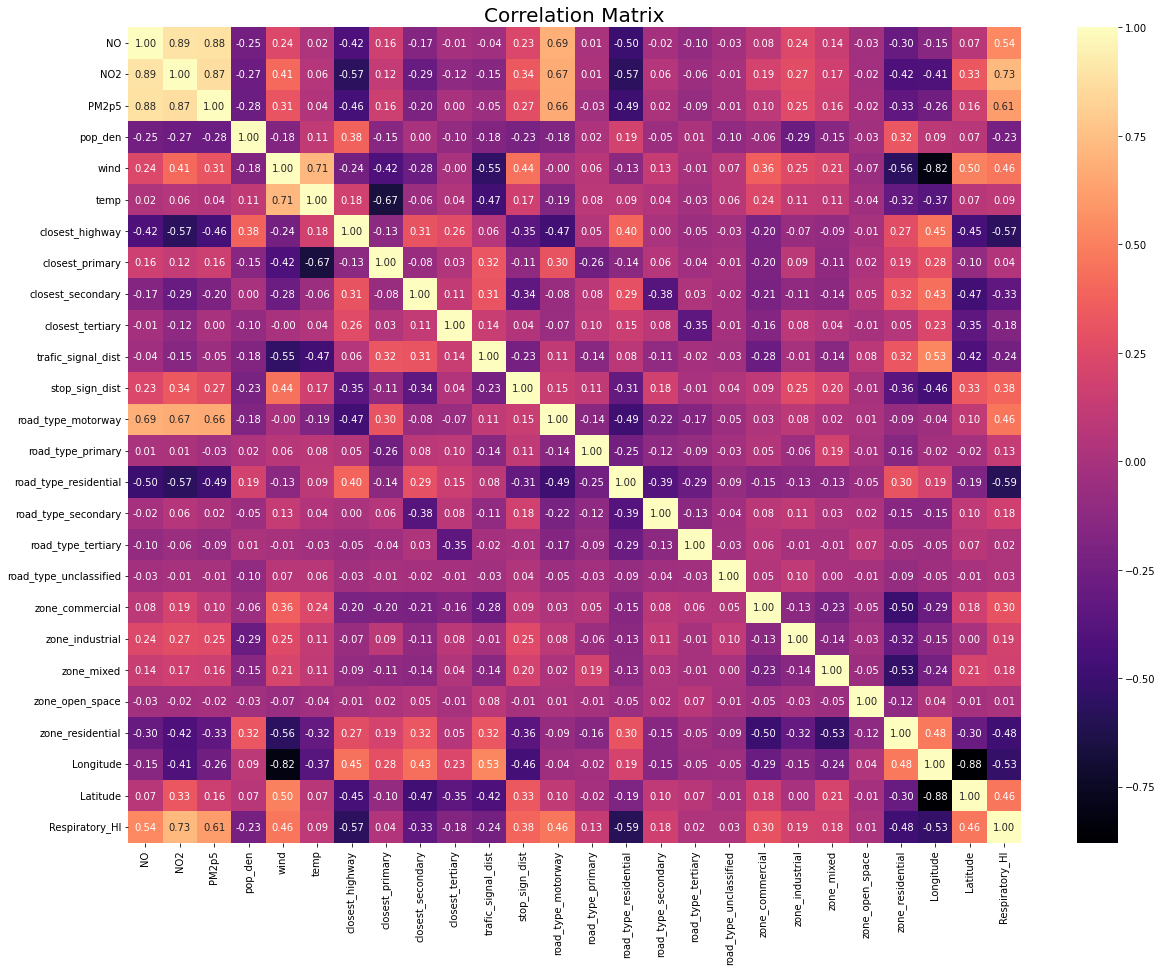

In [78]:
f, ax = plt.subplots(figsize= [20,15])
sns.heatmap(df_vis[numerical].corr(), annot=True, fmt=".2f", ax=ax, cmap = "magma" )
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [86]:
Corr = pd.DataFrame(df_vis[numerical].corr()['Respiratory_HI'].sort_values(ascending=False))
Corr = Corr.iloc[1:,:]
Corr.columns=['Target Correlation']
Corr[:5]

Target Correlation
NO2                           0.728085
PM2p5                         0.613432
NO                            0.535724
Latitude                      0.462347
road_type_motorway            0.459021

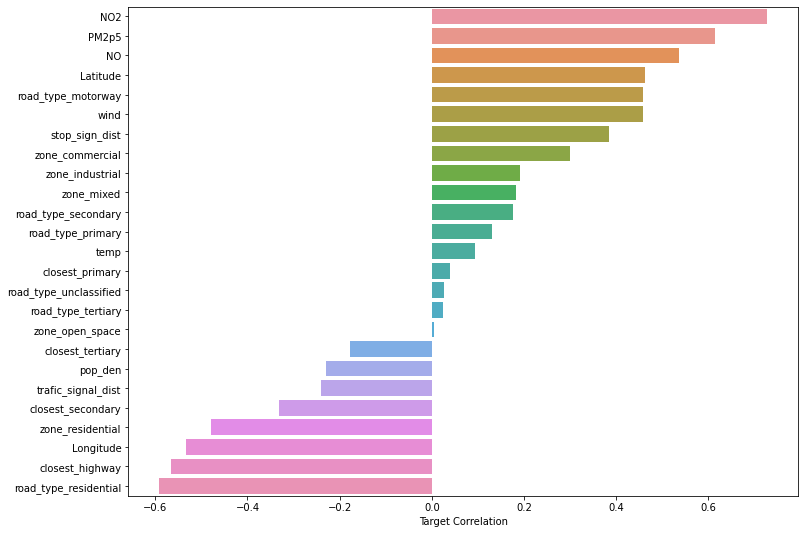

In [88]:
g0 = sns.barplot(x = "Target Correlation", y = Corr.index, data = Corr)
g0.figure.set_size_inches(12,9)

1. NO2 easily invades the deep bronchiole and alveoli of the respiratory tract. And long-term low-concentration inhalation can cause damage to lung tissue and cause pulmonary edema. Studies have shown that the increase of bronchitis symptoms in children with asthma is related to long-term exposure to NO2. Too much O3 in the atmosphere can have an effect on the respiratory system, triggering asthma, reducing lung function and causing lung disease.
2. When PM2.5 enters the lungs, it can block partial tissues of lung, reduce the ventilation function of the local bronchi, and lose the ventilation function of the bronchioles and alveoli. PM2.5 adsorbing harmful gases can irritate or corrode alveolar walls, and long-term effects can damage the respiratory defense function, causing bronchitis, emphysema and bronchial asthma, etc.

In [89]:
gpd_1_vis = gpd_1_city.copy()

### map

Text(0, 0.5, 'Latitude')

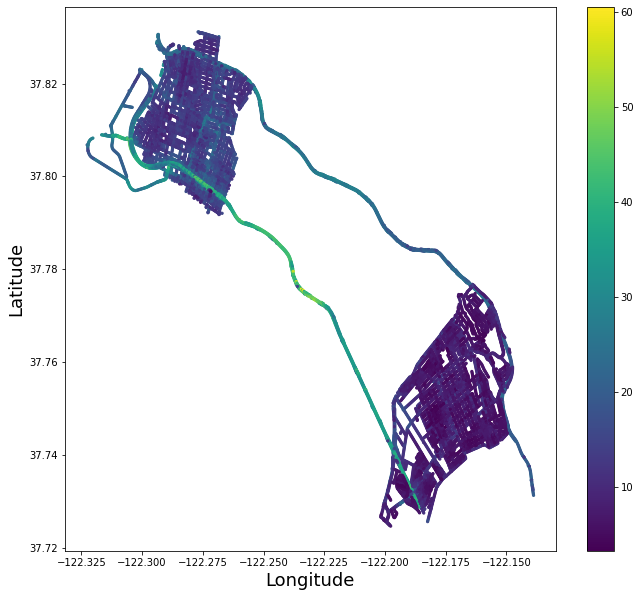

In [90]:
# Plot the overall heatmap that will go into the web-app
plt.figure(figsize = (11, 10))
plt.scatter(gpd_1_vis.Longitude, gpd_1_vis.Latitude, s=5, c = gpd_1_vis.NO2)
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

Text(0, 0.5, 'Latitude')

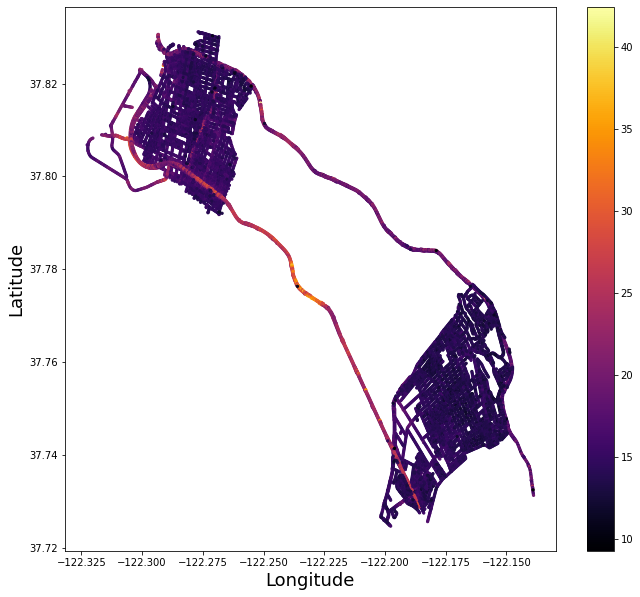

In [91]:
# Plot the overall heatmap that will go into the web-app
plt.figure(figsize = (11, 10))
plt.scatter(gpd_1_vis.Longitude, gpd_1_vis.Latitude, s=5, c = gpd_1_vis.PM2p5, cmap='inferno')
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

### boxplot-roads

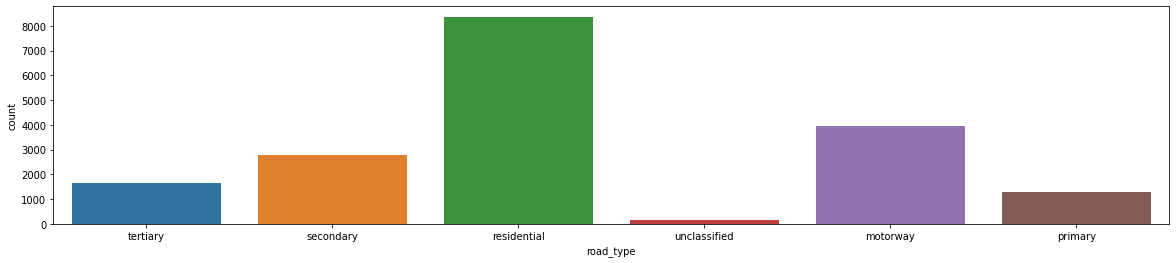

In [92]:
# Check the sizes of data count 
plt.figure(figsize=(20,4))
sns.countplot(x = 'road_type', data = df_vis);

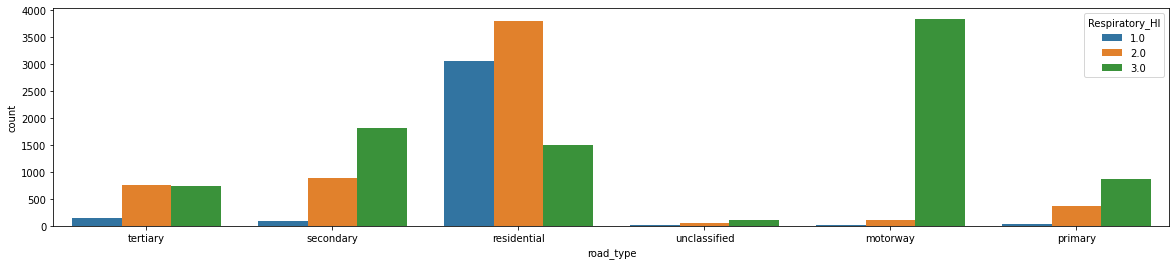

In [93]:
# Road type & health
plt.figure(figsize=(20,4))
sns.countplot(x = 'road_type', hue = df_vis['Respiratory_HI'], data = df_vis);

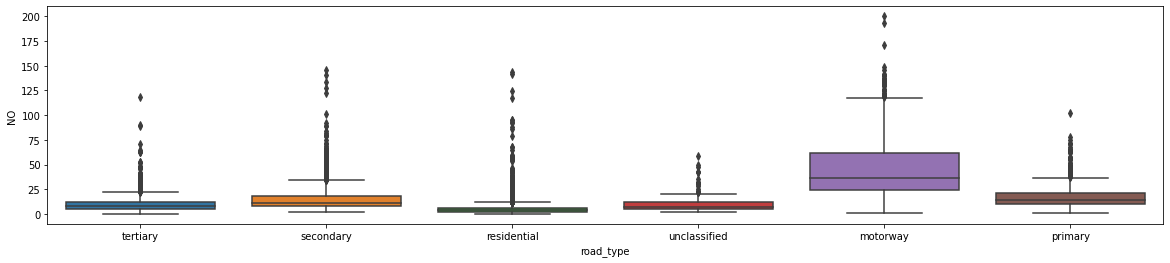

In [94]:
# NO: road type 
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['road_type'], y = df_vis['NO']);

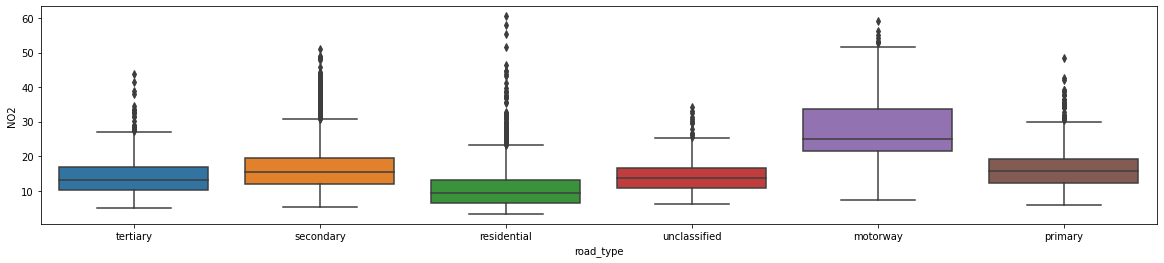

In [95]:
# NO2: road type 
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['road_type'], y = df_vis['NO2']);

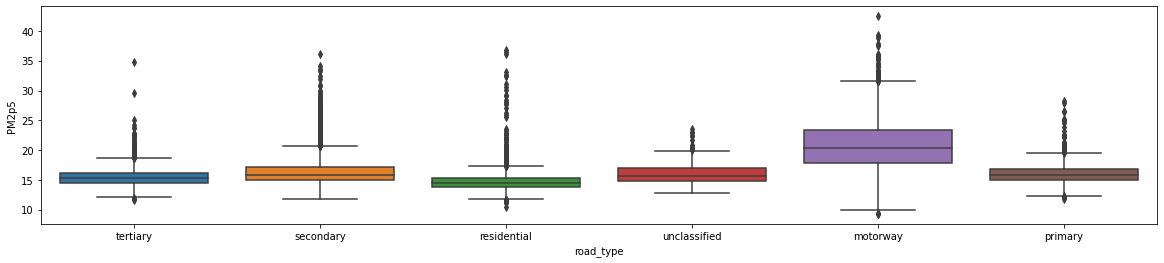

In [96]:
# PM2.5: road type 
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['road_type'], y = df_vis['PM2p5']);

## boxplot - zones

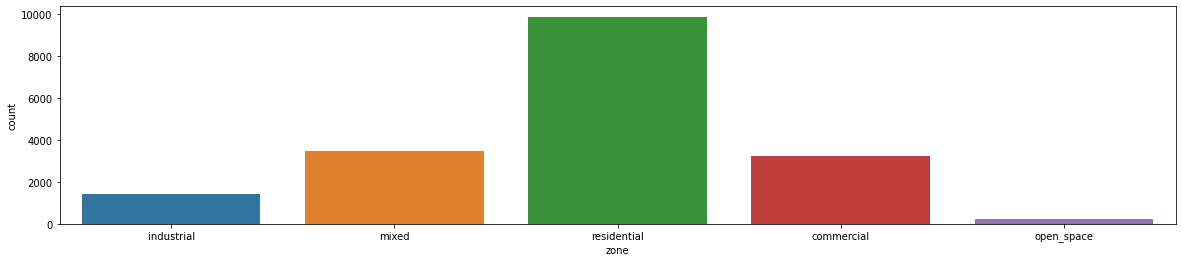

In [97]:
# Check the sizes of data count 
plt.figure(figsize=(20,4))
sns.countplot(x = 'zone', data = df_vis);

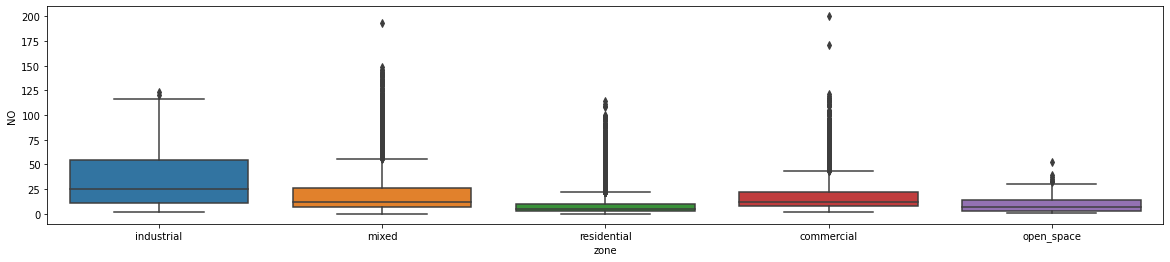

In [98]:
# NO: zone 
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['zone'], y = df_vis['NO']);

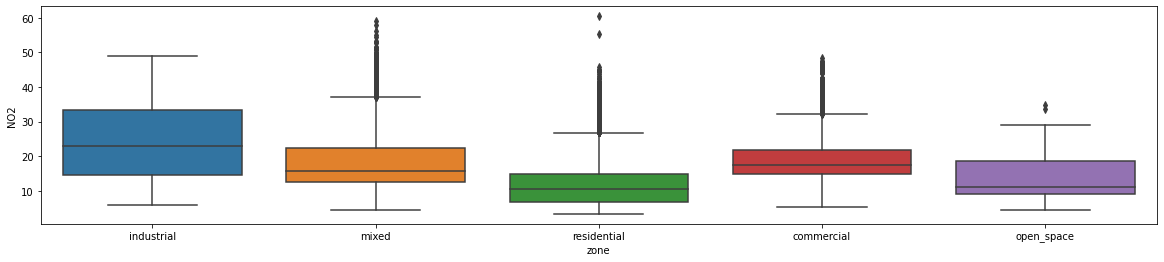

In [99]:
# NO2: zone 
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['zone'], y = df_vis['NO2']);

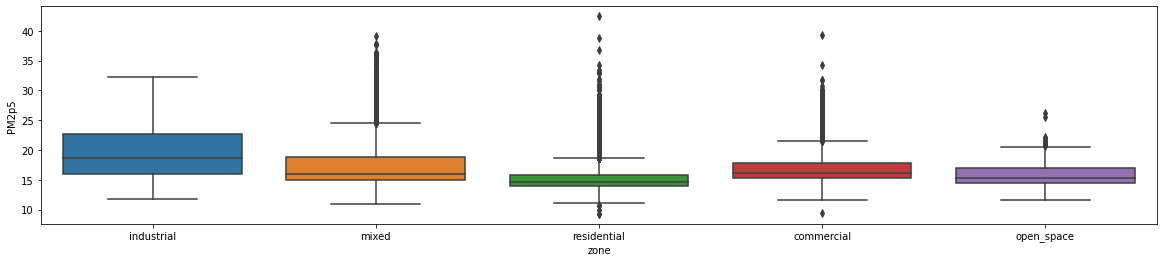

In [100]:
# PM2.5: zone
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['zone'], y = df_vis['PM2p5']);

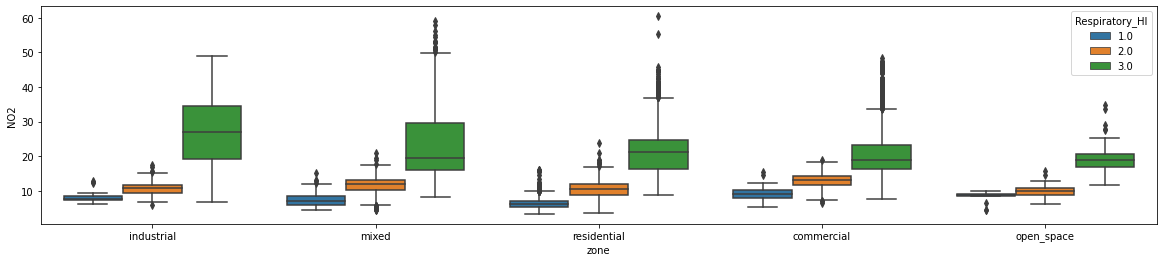

In [101]:
# NO2: zone & health
plt.figure(figsize=(20,4))
sns.boxplot(x = df_vis['zone'], y = df_vis['NO2'], hue = df_vis['Respiratory_HI']);

### distance

Text(0, 0.5, 'PM2.5 (ug/m3)')

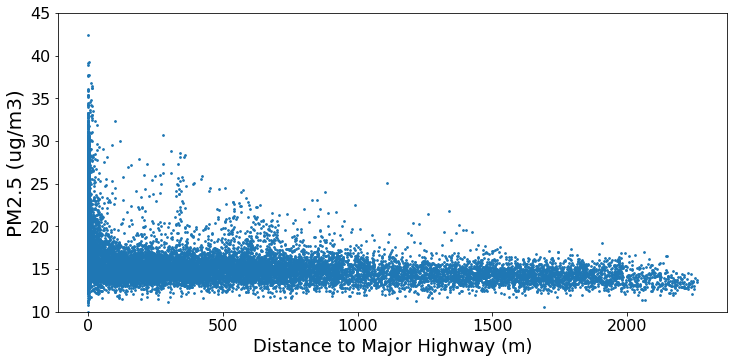

In [102]:
# PM2p5
plt.figure(figsize=(12, 5.5))
plt.scatter(df_vis['closest_highway'], df_vis['PM2p5'], s=3)
plt.ylim(10, 45)
plt.tick_params(labelsize=16)
plt.xlabel('Distance to Major Highway (m)', fontsize=18); plt.ylabel('PM2.5 (ug/m3)', fontsize=20)
# plt.savefig('highway_distance.png', format='png', dpi=300)

# 6. Model

In [104]:
df_model = df_vis.copy()

NO        NO2      PM2p5                     geometry  \
0      23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   
2      23.611111  23.967768  16.210698  POINT (-122.32230 37.80642)   
3      15.714285  18.435184  15.561862  POINT (-122.32230 37.80588)   
4      27.108695  25.797037  17.120884  POINT (-122.32227 37.80669)   
...          ...        ...        ...                          ...   
18214   9.733334  14.588807   9.333887  POINT (-122.25510 37.81945)   
18215  12.857143  15.188906  11.007707  POINT (-122.23603 37.77631)   
18216   9.591837  15.566772   9.922039  POINT (-122.17888 37.78403)   
18217   9.333333   9.039947  11.325624  POINT (-122.15509 37.77014)   
18218  18.842105  16.122072   9.270166  POINT (-122.13903 37.73246)   

           pop_den      wind       temp   Longitude   Latitude  \
0         8.336845  4.133333  14.950001 -122.322594  37.806781   
1         8.336845  4.133333  14.950001 -122.322310  37.806150   
2         8.336845  4.133333  14.950001 -122.322301  37.806420   
3         8.336845  4.133333  14.950001 -122.322299  37.805880   
4         8.336845  4.133333  14.950001 -122.322267  37.806689   
...            ...       ...        ...         ...        ...   
18214  6241.318446  3.950000  15.049999 -122.255100  37.819452   
18215  2351.277070  4.091667  15.166668 -122.236032  37.776312   
18216  2277.042655  3.833333  14.608333 -122.178876  37.784034   
18217  1475.818172  3.766667  14.600001 -122.155090  37.770138   
18218   486.040242  3.816667  15.041669 -122.139033  37.732464   

       Respiratory_HI  ...  road_type_secondary road_type_tertiary  \
0                 3.0  ...                    0                  1   
1                 3.0  ...                    1                  0   
2                 3.0  ...                    1                  0   
3                 3.0  ...                    1                  0   
4                 3.0  ...                    1                  0   
...               ...  ...                  ...                ...   
18214             1.0  ...                    0                  0   
18215             1.0  ...                    0                  0   
18216             1.0  ...                    0                  0   
18217             1.0  ...                    0                  0   
18218             1.0  ...                    0                  0   

       road_type_unclassified  zone_commercial  zone_industrial zone_mixed  \
0                           0                0                1          0   
1                           0                0                1          0   
2                           0                0                1          0   
3                           0                0                1          0   
4                           0                0                1          0   
...                       ...              ...              ...        ...   
18214                       0                0                0          0   
18215                       0                0                0          1   
18216                       0                0                0          0   
18217                       0                0                0          0   
18218                       0                0                0          0   

      zone_open_space zone_residential         zone  road_type  
0                   0                0   industrial   tertiary  
1                   0                0   industrial  secondary  
2                   0                0   industrial  secondary  
3                   0                0   industrial  secondary  
4                   0                0   industrial  secondary  
...               ...              ...          ...        ...  
18214               0                1  residential   motorway  
18215               0                0        mixed   motorway  
18216

In [105]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

    
def pred_summary(pred, ytest, limit = 200):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.tick_params(labelsize=18)
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))
    
    
    
def plot_corr(df, size=10, MI = False):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    if MI == False:
        corr = df.corr()
    else:
        K = df.shape[1]
        corr = np.empty((K, K), dtype=float)
        
        for i, ac in enumerate(X.columns):
            for j, bc in enumerate(X.columns):
                MI = mutual_information(X.loc[:, ac], X.loc[:, bc], bins=10, normalize=True)
                corr[i, j] = MI
        
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

## Feature selection

In [106]:
df_model[numerical].columns

Index(['NO', 'NO2', 'PM2p5', 'pop_den', 'wind', 'temp', 'closest_highway',
       'closest_primary', 'closest_secondary', 'closest_tertiary',
       'trafic_signal_dist', 'stop_sign_dist', 'road_type_motorway',
       'road_type_primary', 'road_type_residential', 'road_type_secondary',
       'road_type_tertiary', 'road_type_unclassified', 'zone_commercial',
       'zone_industrial', 'zone_mixed', 'zone_open_space', 'zone_residential',
       'Longitude', 'Latitude', 'Respiratory_HI'],
      dtype='object')

In [107]:
X = df_model[numerical].drop(['Respiratory_HI', 'Longitude','Latitude', 'road_type_unclassified','NO', 'NO2', 'PM2p5'], axis=1)

X.columns

Index(['pop_den', 'wind', 'temp', 'closest_highway', 'closest_primary',
       'closest_secondary', 'closest_tertiary', 'trafic_signal_dist',
       'stop_sign_dist', 'road_type_motorway', 'road_type_primary',
       'road_type_residential', 'road_type_secondary', 'road_type_tertiary',
       'zone_commercial', 'zone_industrial', 'zone_mixed', 'zone_open_space',
       'zone_residential'],
      dtype='object')

## Model Selection (hw)

## Train-Test Split & Feature Scaling

In [108]:
# NO 
y_NO = df_model['NO']

# NO Split the Data
X_train_NO, X_test_NO, y_train_NO, y_test_NO = model_selection.train_test_split(X, y_NO, test_size=0.25, random_state= 1)
print('training data has ' + str(X_train_NO.shape[0]) + ' observation with ' + str(X_train_NO.shape[1]) + ' features')
print('test data has ' + str(X_test_NO.shape[0]) + ' observation with ' + str(X_test_NO.shape[1]) + ' features')


# # Feature Scaling 
# scaler = StandardScaler()                               # initialize the class and call it scaler
# scaler.fit(X_train_NO)                                  # fit = training data, means recalculating the data to have a mean of 0 and a std of 1 (btw, normalization typicallu means rescales the values into a range of [0,1])
# X_train_NO = scaler.transform(X_train_NO)               # apply above-calculated mean&std to standardize X_train data
# X_test_NO = scaler.transform(X_test_NO)                 # apply above-calculated min&std to X_test data (testing data could only use parameters from training data)

training data has 13664 observation with 19 features
test data has 4555 observation with 19 features


In [109]:
# NO2
y_NO2 = df_model['NO2']


# NO2 Split the Data
X_train_NO2, X_test_NO2, y_train_NO2, y_test_NO2 = model_selection.train_test_split(X, y_NO2, test_size=0.25, random_state= 1)
print('training data has ' + str(X_train_NO2.shape[0]) + ' observation with ' + str(X_train_NO2.shape[1]) + ' features')
print('test data has ' + str(X_test_NO2.shape[0]) + ' observation with ' + str(X_test_NO2.shape[1]) + ' features')


# # Feature Scaling
# scaler = StandardScaler()                               
# scaler.fit(X_train_NO2)                                   
# X_train_NO2 = scaler.transform(X_train_NO2)              
# X_test_NO2 = scaler.transform(X_test_NO2)              

training data has 13664 observation with 19 features
test data has 4555 observation with 19 features


In [110]:
y_PM = df_model['PM2p5']


# NO2 Split the Data
X_train_PM, X_test_PM, y_train_PM, y_test_PM = model_selection.train_test_split(X, y_PM, test_size=0.25, random_state= 1)
print('training data has ' + str(X_train_PM.shape[0]) + ' observation with ' + str(X_train_PM.shape[1]) + ' features')
print('test data has ' + str(X_test_PM.shape[0]) + ' observation with ' + str(X_test_PM.shape[1]) + ' features')


# # Feature Scaling
# scaler = StandardScaler()                         
# scaler.fit(X_train_PM)                            
# X_train_PM = scaler.transform(X_train_PM)            
# X_test_PM = scaler.transform(X_test_PM)     

training data has 13664 observation with 19 features
test data has 4555 observation with 19 features


## NO2

### ensemble learning - Bagging

In [111]:
# Use the same random forest gridsearch as above
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [150, 200]}

forest_grid_no2 = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid_no2.fit(X_train_NO2, y_train_NO2)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=2),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [112]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid_no2.best_score_)))
print(forest_grid_no2.best_estimator_)

Best score (RMSE) 2.3081071823959696
RandomForestRegressor(max_features=10, n_estimators=200, n_jobs=2)


RMSE 2.1244063776386812
R2 0.9443955052487847


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Observed NO$_2$')

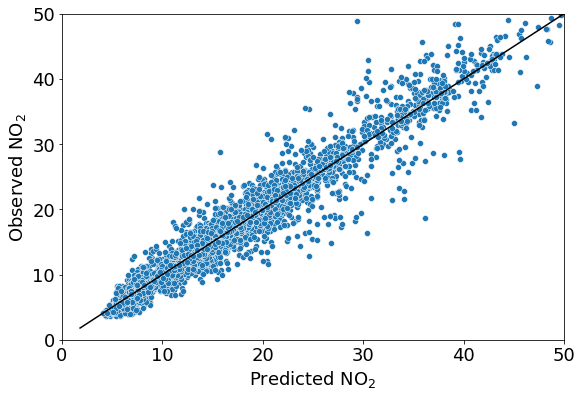

In [113]:
fig = plt.figure(figsize=(9,6))
forest_out_no2 = forest_grid_no2.predict(X_test_NO2)
pred_summary(forest_out_no2, y_test_NO2, limit=50)
plt.xlabel('Predicted NO$_2$', fontsize = 18); plt.ylabel('Observed NO$_2$', fontsize=18)

In [114]:
FI_rf = pd.DataFrame(forest_grid_no2.best_estimator_.feature_importances_, index=X_train_NO2.columns, columns=['Feature Importance (RF)'])
FI_rf = FI_rf.sort_values(by='Feature Importance (RF)',ascending=False)
FI_rf

Feature Importance (RF)
closest_highway                       0.307292
road_type_motorway                    0.169434
wind                                  0.138384
temp                                  0.067328
road_type_residential                 0.057591
pop_den                               0.046639
closest_primary                       0.040228
closest_tertiary                      0.032985
zone_residential                      0.032672
stop_sign_dist                        0.032191
closest_secondary                     0.031607
trafic_signal_dist                    0.024480
zone_industrial                       0.006361
zone_mixed                            0.004029
zone_commercial                       0.003923
road_type_secondary                   0.002618
road_type_primary                     0.001152
road_type_tertiary                    0.001007
zone_open_space                       0.000080

### ensemble learning - Boosting

In [115]:
# Use the same random forest gridsearch as above
gb_forest = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10],
          'learning_rate': [0.05, 0.1, 0.5],
          'n_estimators': [150, 200]}

gb_forest_grid_no2 = GridSearchCV(gb_forest, params, cv=5, scoring = 'neg_mean_squared_error')
gb_forest_grid_no2.fit(X_train_NO2, y_train_NO2)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [116]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(gb_forest_grid_no2.best_score_)))
print(gb_forest_grid_no2.best_estimator_)

Best score (RMSE) 2.9828307012598785
GradientBoostingRegressor(learning_rate=0.5, max_features=10, n_estimators=200)


RMSE 2.832762603978948
R2 0.901132155251254


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Observed NO$_2$')

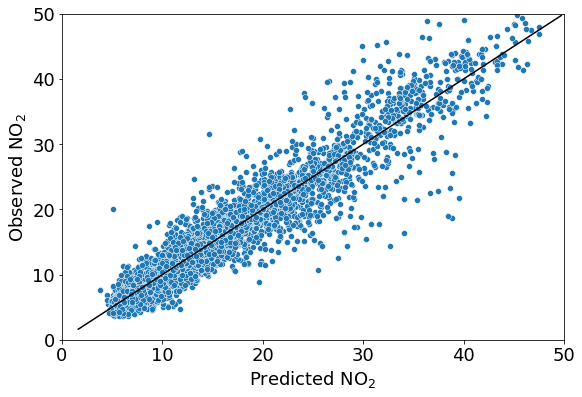

In [117]:
fig = plt.figure(figsize=(9,6))
gb_forest_out_no2 = gb_forest_grid_no2.predict(X_test_NO2)
pred_summary(gb_forest_out_no2, y_test_NO2, limit=50)
plt.xlabel('Predicted NO$_2$', fontsize = 18); plt.ylabel('Observed NO$_2$', fontsize=18)

In [118]:
FI_gb = pd.DataFrame(gb_forest_grid_no2.best_estimator_.feature_importances_, index=X_train_NO2.columns, columns=['Feature Importance (GB)'])
FI_gb = FI_gb.sort_values(by='Feature Importance (GB)',ascending=False)
FI_gb

Feature Importance (GB)
road_type_motorway                    0.365037
closest_highway                       0.198260
wind                                  0.109626
zone_residential                      0.086596
temp                                  0.064593
pop_den                               0.034182
closest_tertiary                      0.022703
closest_secondary                     0.021002
closest_primary                       0.018394
road_type_residential                 0.016138
stop_sign_dist                        0.015754
road_type_secondary                   0.013322
zone_industrial                       0.012620
trafic_signal_dist                    0.011620
zone_commercial                       0.005197
road_type_primary                     0.001848
zone_mixed                            0.001746
zone_open_space                       0.001054
road_type_tertiary                    0.000310

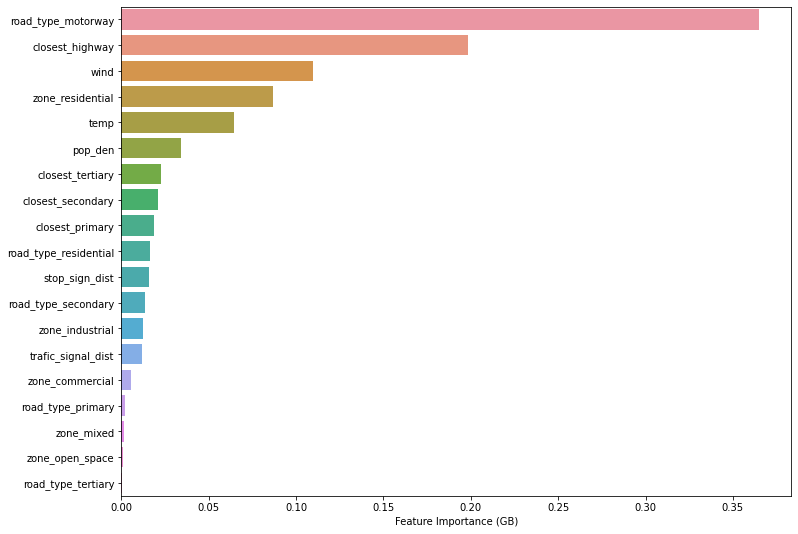

In [119]:
g2 = sns.barplot(x="Feature Importance (GB)", y=FI_gb.index, data=FI_gb)
g2.figure.set_size_inches(12, 9)

### permutation Importance

In [120]:
# (1) Set the best parameters from hyperparameter tuning
grid_search_best_no2 = forest_grid_no2.best_estimator_
print('Parameters currently in use:\n')
pprint(grid_search_best_no2.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 10,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [121]:
# (2) Permutation Importance - Random Forest
PI_no2 = permutation_importance(grid_search_best_no2, X_test_NO2, y_test_NO2, n_repeats=5, random_state=1)



PI_res = pd.DataFrame(data=np.transpose([PI_no2['importances_mean'],PI_no2['importances_std']]), 
             index = X_test_NO2.columns,columns=['PI_mean','PI_std'])
PI_res = PI_res.sort_values(by='PI_mean',ascending=False)
PI_res

PI_mean    PI_std
closest_highway        0.515154  0.008260
wind                   0.284371  0.003777
road_type_motorway     0.111561  0.002663
temp                   0.093810  0.002751
closest_primary        0.064817  0.001417
pop_den                0.046518  0.002326
closest_secondary      0.040541  0.002392
road_type_residential  0.036454  0.000782
stop_sign_dist         0.033713  0.001084
closest_tertiary       0.025210  0.001199
trafic_signal_dist     0.023322  0.001150
zone_residential       0.014357  0.000634
zone_industrial        0.004234  0.000388
zone_mixed             0.003745  0.000272
zone_commercial        0.002899  0.000147
road_type_secondary    0.001046  0.000122
road_type_primary      0.000434  0.000029
road_type_tertiary     0.000234  0.000053
zone_open_space       -0.000001  0.000006

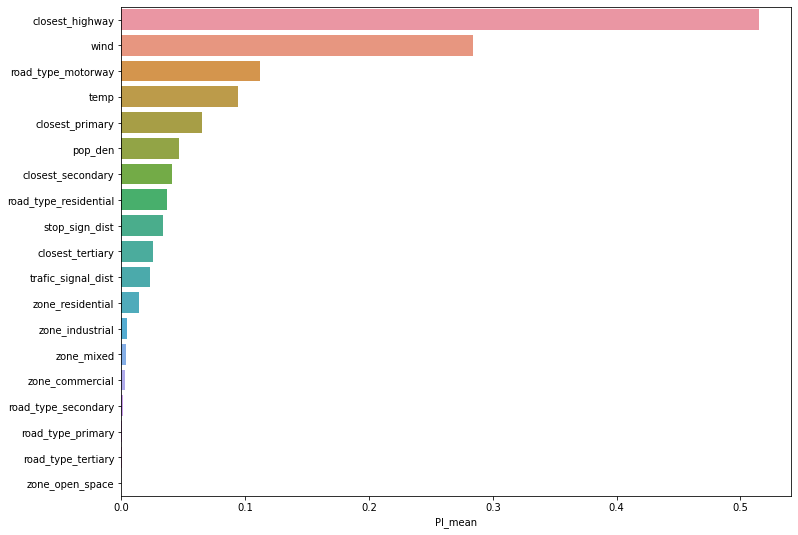

In [122]:
g1 = sns.barplot(x="PI_mean", y=PI_res.index, data=PI_res)
g1.figure.set_size_inches(12, 9)

### result summary

In [123]:
# Summary

summary_0 = pd.DataFrame({'Random Forest':list(FI_rf.index),
              'Gradient Boost':list(FI_gb.index),
               'Permutation Importance':list(PI_res.index)})
summary_0

Random Forest         Gradient Boost Permutation Importance
0         closest_highway     road_type_motorway        closest_highway
1      road_type_motorway        closest_highway                   wind
2                    wind                   wind     road_type_motorway
3                    temp       zone_residential                   temp
4   road_type_residential                   temp        closest_primary
5                 pop_den                pop_den                pop_den
6         closest_primary       closest_tertiary      closest_secondary
7        closest_tertiary      closest_secondary  road_type_residential
8        zone_residential        closest_primary         stop_sign_dist
9          stop_sign_dist  road_type_residential       closest_tertiary
10      closest_secondary         stop_sign_dist     trafic_signal_dist
11     trafic_signal_dist    road_type_secondary       zone_residential
12        zone_industrial        zone_industrial        zone_industrial
13             zone_mixed     trafic_signal_dist             zone_mixed
14        zone_commercial        zone_commercial        zone_commercial
15    road_type_secondary      road_type_primary    road_type_secondary
16      road_type_primary             zone_mixed      road_type_primary
17     road_type_tertiary        zone_open_space     road_type_tertiary
18        zone_open_space     road_type_tertiary        zone_open_space

## NO (HW)

### Ensemble learning - Bagging

In [152]:
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [150, 200]}

forest_grid_no = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid_no.fit(X_train_NO, y_train_NO)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=2),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [151]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid_no.best_score_)))
print(forest_grid_no.best_estimator_)

Best score (RMSE) 6.34963190558276
RandomForestRegressor(max_features=8, n_estimators=200, n_jobs=2)


RMSE 5.865537746938252
R2 0.9191233610159715


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Observed NO')

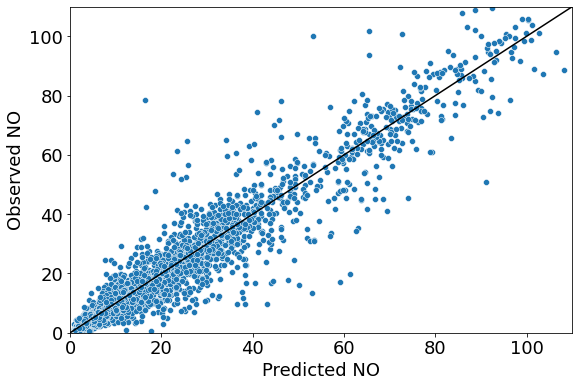

In [154]:
fig = plt.figure(figsize=(9,6))
forest_NO = forest_grid_no.predict(X_test_NO)
pred_summary(forest_NO, y_test_NO, limit=110)
plt.xlabel('Predicted NO', fontsize = 18); plt.ylabel('Observed NO', fontsize=18)

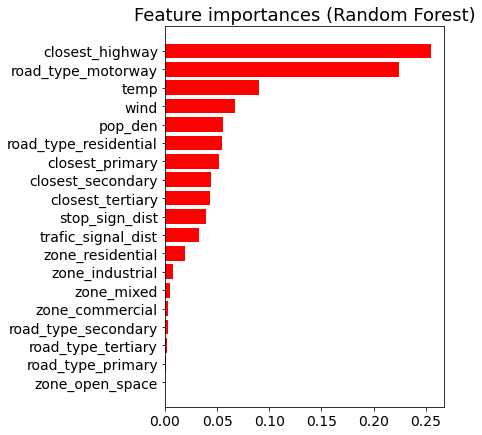

In [155]:
features = X_train_NO.columns
importance = forest_grid_no.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances (Random Forest)", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

### Ensemble learning - Boosting

In [156]:
# Use the same random forest gridsearch as above
gb_forest = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10],
          'learning_rate': [0.05, 0.1, 0.5],
          'n_estimators': [150, 200]}

gb_forest_grid_no = GridSearchCV(gb_forest, params, cv=5, scoring = 'neg_mean_squared_error')
gb_forest_grid_no.fit(X_train_NO, y_train_NO)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [157]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(gb_forest_grid_no.best_score_)))
print(gb_forest_grid_no.best_estimator_)

Best score (RMSE) 7.9846628279728735
GradientBoostingRegressor(learning_rate=0.5, max_features=8, n_estimators=200)


RMSE 7.563777907297563
R2 0.8655115576779479


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Observed NO')

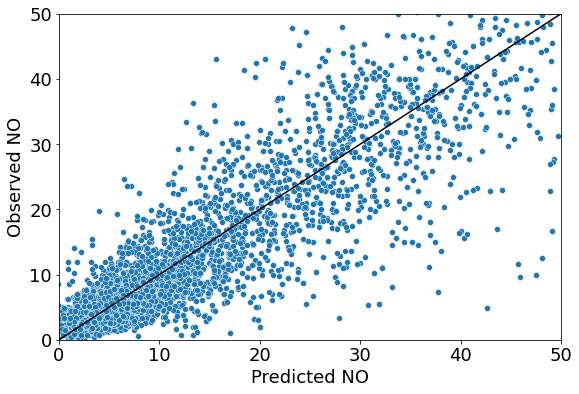

In [158]:
fig = plt.figure(figsize=(9,6))
gb_forest_out_no = gb_forest_grid_no.predict(X_test_NO)
pred_summary(gb_forest_out_no, y_test_NO, limit=50)
plt.xlabel('Predicted NO', fontsize = 18); plt.ylabel('Observed NO', fontsize=18)

In [159]:
FI_gb = pd.DataFrame(gb_forest_grid_no.best_estimator_.feature_importances_, index=X_train_NO.columns, columns=['Feature Importance (GB)'])
FI_gb = FI_gb.sort_values(by='Feature Importance (GB)',ascending=False)
FI_gb

Feature Importance (GB)
road_type_motorway                    0.408879
closest_highway                       0.163593
pop_den                               0.081330
temp                                  0.075688
wind                                  0.064164
road_type_residential                 0.047202
zone_residential                      0.034158
closest_secondary                     0.030720
closest_primary                       0.030544
closest_tertiary                      0.018121
stop_sign_dist                        0.016602
trafic_signal_dist                    0.015827
zone_mixed                            0.004947
zone_industrial                       0.004832
road_type_primary                     0.001284
zone_commercial                       0.001125
road_type_secondary                   0.000608
zone_open_space                       0.000212
road_type_tertiary                    0.000163

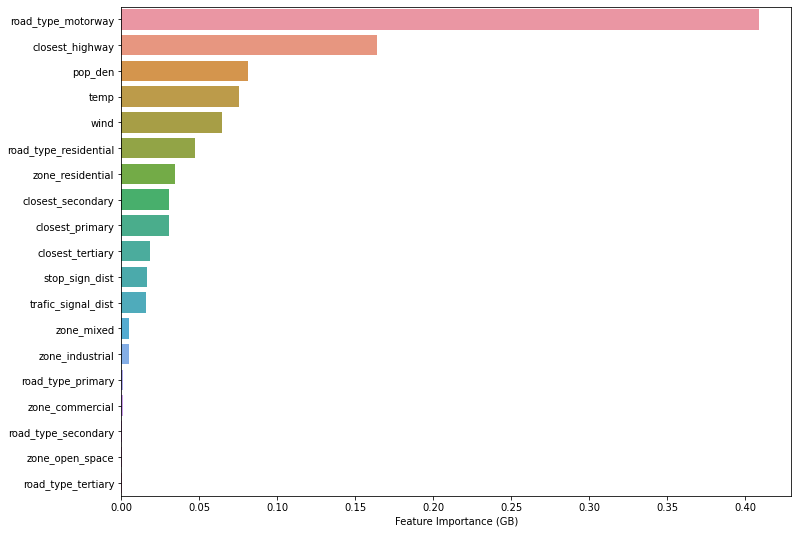

In [160]:
g2 = sns.barplot(x="Feature Importance (GB)", y=FI_gb.index, data=FI_gb)
g2.figure.set_size_inches(12, 9)

### permutation Importance

In [161]:
# (1) Set the best parameters from hyperparameter tuning
grid_search_best_no = forest_grid_no.best_estimator_
print('Parameters currently in use:\n')
pprint(grid_search_best_no.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 8,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 2,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [162]:
# (2) Permutation Importance - Random Forest
PI_no = permutation_importance(grid_search_best_no, X_test_NO, y_test_NO, n_repeats=5, random_state=1)



PI_res = pd.DataFrame(data=np.transpose([PI_no['importances_mean'],PI_no['importances_std']]), 
             index = X_test_NO.columns,columns=['PI_mean','PI_std'])
PI_res = PI_res.sort_values(by='PI_mean',ascending=False)
PI_res

PI_mean    PI_std
closest_highway        0.434053  0.011182
road_type_motorway     0.206679  0.006713
temp                   0.135709  0.002567
wind                   0.097088  0.003048
pop_den                0.056065  0.002445
closest_primary        0.049185  0.003995
closest_secondary      0.047571  0.002721
road_type_residential  0.039329  0.002744
stop_sign_dist         0.035692  0.001983
closest_tertiary       0.034015  0.001499
trafic_signal_dist     0.021820  0.001123
zone_residential       0.018663  0.002077
zone_industrial        0.006023  0.000429
zone_mixed             0.003586  0.000445
road_type_secondary    0.001324  0.000166
zone_commercial        0.001253  0.000260
road_type_primary      0.000725  0.000054
road_type_tertiary     0.000602  0.000137
zone_open_space        0.000021  0.000005

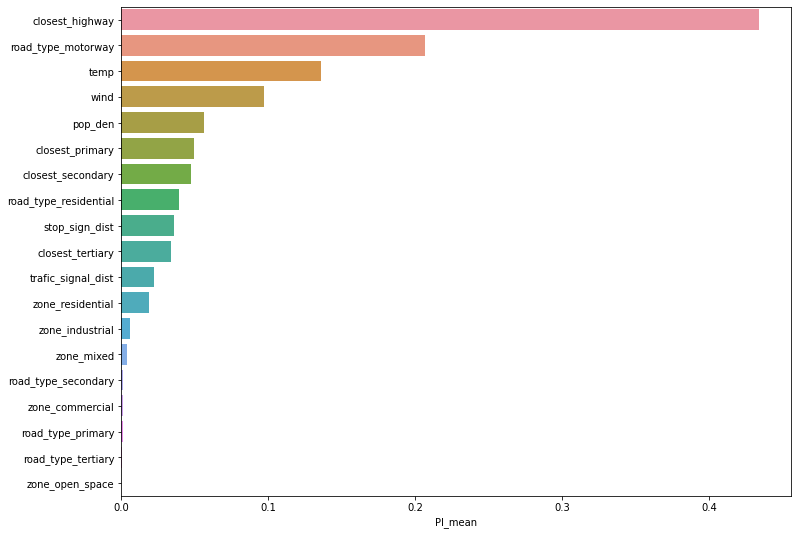

In [163]:
g1 = sns.barplot(x="PI_mean", y=PI_res.index, data=PI_res)
g1.figure.set_size_inches(12, 9)

### result summary

In [164]:
# Summary

summary_0 = pd.DataFrame({'Random Forest':list(FI_rf.index),
              'Gradient Boost':list(FI_gb.index),
               'Permutation Importance':list(PI_res.index)})
summary_0

Random Forest         Gradient Boost Permutation Importance
0         closest_highway     road_type_motorway        closest_highway
1      road_type_motorway        closest_highway     road_type_motorway
2                    wind                pop_den                   temp
3                    temp                   temp                   wind
4   road_type_residential                   wind                pop_den
5                 pop_den  road_type_residential        closest_primary
6         closest_primary       zone_residential      closest_secondary
7        closest_tertiary      closest_secondary  road_type_residential
8        zone_residential        closest_primary         stop_sign_dist
9          stop_sign_dist       closest_tertiary       closest_tertiary
10      closest_secondary         stop_sign_dist     trafic_signal_dist
11     trafic_signal_dist     trafic_signal_dist       zone_residential
12        zone_industrial             zone_mixed        zone_industrial
13             zone_mixed        zone_industrial             zone_mixed
14        zone_commercial      road_type_primary    road_type_secondary
15    road_type_secondary        zone_commercial        zone_commercial
16      road_type_primary    road_type_secondary      road_type_primary
17     road_type_tertiary        zone_open_space     road_type_tertiary
18        zone_open_space     road_type_tertiary        zone_open_space

## PM2.5

### Ensemble learning - Bagging

In [165]:
# Use the same random forest gridsearch as above
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10],
          'n_estimators': [150, 200, 250]}

forest_grid_pm = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid_pm.fit(X_train_PM, y_train_PM)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=2),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200, 250]},
             scoring='neg_mean_squared_error')

In [166]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid_pm.best_score_)))
print(forest_grid_pm.best_estimator_)

Best score (RMSE) 1.4109078770680583
RandomForestRegressor(max_features=8, n_estimators=250, n_jobs=2)


/Users/fangyusu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


RMSE 1.3337686425341564
R2 0.849138705736401


Text(0, 0.5, 'Observed PM')

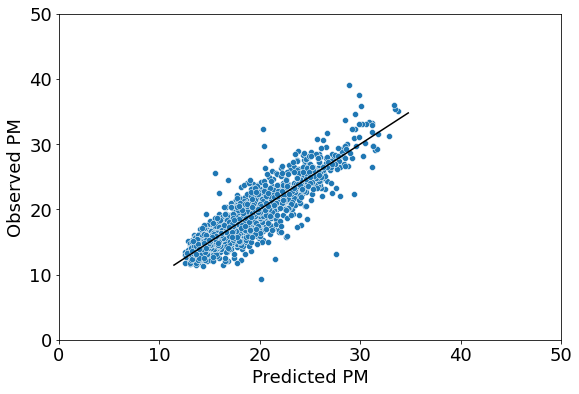

In [167]:
fig = plt.figure(figsize=(9,6))
forest_out_pm = forest_grid_pm.predict(X_test_PM)
pred_summary(forest_out_pm, y_test_PM, limit=50)
plt.xlabel('Predicted PM', fontsize = 18); plt.ylabel('Observed PM', fontsize=18)

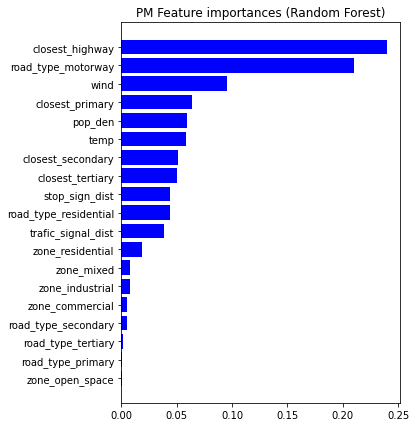

In [168]:
features = X.columns
importance = forest_grid_pm.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("PM Feature importances (Random Forest)")
plt.barh(features[indices], importance[indices],
       color="b",  align="center");